In [17]:
import subprocess

# subprocess.run(['pip3', 'install', '--upgrade', 'pip'], check=True)
# subprocess.run(['sudo', 'apt-get', 'install', 'gdal-bin', 'libgdal-dev', 'libspatialindex-dev'], check=True, input=b'y\n')

# packages = ['cython','pyproj','geopandas','pandas','numpy','shapely','fiona','rasterio','scipy', 'rtree','pygeos']

# for p in packages:
#   subprocess.check_call(['pip3', 'install', p])

import os
import shutil
import tempfile
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon, box, mapping
from pyproj import CRS
import fiona
import requests
import json
import rasterio
from rasterio.mask import mask
from rasterio.enums import Resampling
from scipy.spatial import Voronoi

fiona.drvsupport.supported_drivers['KML'] = 'rw'

def download_file(url, save_path):
    response = requests.get(url)
    if response.status_code == 200:
        with open(save_path, 'wb') as file:
            file.write(response.content)
        print(f"File downloaded successfully and saved as '{save_path}'.")
    else:
        print(f"Error occurred while downloading file from '{url}'.")
        
def get_metadata(attribute):
    curl_command = [
        "curl",
        "-H",
        "Metadata-Flavor: Google",
        f"http://metadata/computeMetadata/v1/instance/attributes/{attribute}"
    ]
    result = subprocess.run(curl_command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
    output = result.stdout.strip()
    return output

def expand_to_gcps(focal_poly, gcps, gcp_cutoff=5, step_sz=30, base_buffer=50):
    focal_poly = focal_poly.buffer(base_buffer)
    count = sum(gcps.within(focal_poly.geometry.iloc[0]))
    
    if count < gcp_cutoff:
        while count < gcp_cutoff:
            focal_poly = focal_poly.buffer(step_sz)
            count = sum(gcps.within(focal_poly.geometry.iloc[0]))
    
    return focal_poly

def load_kml(path):
  df = gpd.GeoDataFrame()

  # iterate over layers
  for layer in fiona.listlayers(path):
      s = gpd.read_file(path, driver='KML', layer=layer)
      df = pd.concat([df, s], ignore_index=True)
  return df

def copy_to_gcs(local_file_path, bucket_name):
    command = ['gsutil', 'cp', '-r', local_file_path, 'gs://{}/'.format(bucket_name)]
    try:
        subprocess.run(command, check=True)
        print('File copied to Google Cloud Storage successfully.')
    except subprocess.CalledProcessError as e:
        print('Error occurred while copying the file to Google Cloud Storage:')
        print(e)

def mask_to_gdf(gdf, raster_path, output_path):
    # Read the raster file
    src = rasterio.open(raster_path)

    # Reproject the GeoDataFrame to match the projection of the raster, if needed
    gdf = gdf.to_crs(src.crs)

    # Mask the raster using the GeoDataFrame's geometry
    out_image, out_transform = mask(src, gdf.geometry, crop=True)

    # Update the metadata of the cropped raster
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform,
        "dtype": out_image.dtype,
        "compress": src.compression.value if src.compression else "none"
    })

    # Save the cropped raster to a new file
    with rasterio.open(output_path, 'w', **out_meta) as dst:
        # Use the original raster's block size and resampling method for better compression
        dst.write(out_image)

def process_images(batch, output_bucket, ortho_res, cutline, suffix, gcp_list_path):
   # Create a temporary directory
    temp_dir = tempfile.mkdtemp()

    # Create an 'images' subdirectory
    images_dir = os.path.join(temp_dir, 'images')
    os.mkdir(images_dir)

    if gcp_list_path is not None:
        shutil.move(gcp_list_path, temp_dir)

    for url in batch:
        try:
            subprocess.run(['wget', '-P', images_dir, url], check=True)
            print(f"File downloaded successfully from {url}")
        except subprocess.CalledProcessError as e:
            print(f"Error occurred while downloading file from {url}:")
            print(e)

    # Execute OpenDroneMap Docker command
    docker_command = [
        "sudo", "docker", "run", "--rm",
        "-v", "{}:/datasets/code".format(temp_dir),
        "opendronemap/odm", "--project-path", "/datasets",
        "--orthophoto-resolution", f"{ortho_res}",
        "--fast-orthophoto",
        "--force-gps"
    ]

    process = subprocess.run(docker_command, check=True)
    
    ortho = os.path.join(temp_dir,'odm_orthophoto/odm_orthophoto.tif')
    report = os.path.join(temp_dir,'odm_report/report.pdf')
    ortho_new = ortho.replace('.tif',f'_{suffix}.tif')
    report_new = report.replace('.pdf',f'_{suffix}.pdf')
    
    mask_to_gdf(cutline, ortho, ortho_new)
    os.rename(report, report_new)

    focal_files = [ortho_new, report_new]
    
    for f in focal_files:
        copy_to_gcs(f, output_bucket)
    
    # Cleanup: Remove temporary directory
    shutil.rmtree(temp_dir)

def stop_instance(instance_name):
    # Construct the gsutil command to stop the instance
    gsutil_command = f'gsutil compute instances stop {instance_name}'

    try:
        # Execute the gsutil command using subprocess
        subprocess.run(gsutil_command, shell=True, check=True)
        print(f'Successfully stopped instance: {instance_name}')
    except subprocess.CalledProcessError as e:
        print(f'Error stopping instance: {instance_name}')
        print(e)

def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Source: https://gist.github.com/pv/8036995
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

def generate_points(poly, num, seed=None):
    np.random.seed(seed)
    points = []
    minx, miny, maxx, maxy = poly.bounds
    while len(points) < num:
        random_point = Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
        if (random_point.within(poly)):
            points.append(random_point)
    return [point.coords[0] for point in points]

def calculate_voronoi_complexity(poly, points):
    # compute Voronoi tesselation
    vor = Voronoi(points)
    
    # create finite Voronoi polygons
    regions, vertices = voronoi_finite_polygons_2d(vor)
    
    # construct the polygons and intersect with the original one
    voronoi_polygons = [poly.intersection(Polygon(vertices[region])) for region in regions]
    
    # return only the valid ones (completely inside the original polygon)
    valid_polygons = [p for p in voronoi_polygons if p.is_valid]

    # calculate the perimeter and areas of each valid polygon
    perimeters = [p.length for p in valid_polygons]
    areas = [p.area for p in valid_polygons]
    complexity = [x / y for x, y in zip(perimeters, areas)]
    
    return complexity, valid_polygons

def optimize_voronoi_complexity(poly, num, max_iterations=1000, learning_rate=0.1, seed=None):
    points = generate_points(poly, num, seed)
    np.random.seed(seed)
    mns = [] # to store complexity means at each iteration
    
    for i in range(max_iterations):
        complexity, polygons = calculate_voronoi_complexity(poly, points)
        mn = np.mean(complexity)
        mns.append(mn) # append current std dev to the list

        # randomly select a point
        point_idx = np.random.randint(0, len(points))
        current_point = Point(points[point_idx])
        
        # Compute gradients by trying small movements in each direction
        min_mn = mn
        min_mn_direction = None
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            new_point = Point(current_point.x + dx * learning_rate, current_point.y + dy * learning_rate)
            new_points = points.copy()
            new_points[point_idx] = (new_point.x, new_point.y)
            
            new_complexity, _ = calculate_voronoi_complexity(poly, new_points)
            new_mn = np.mean(new_complexity)
            
            if new_mn < min_mn:
                min_mn = new_mn
                min_mn_direction = (dx, dy)
        
        # If we found a direction that decreases the mean complexity, move the point
        if min_mn_direction is not None:
            dx, dy = min_mn_direction
            points[point_idx] = (current_point.x + dx * learning_rate, current_point.y + dy * learning_rate)
    
    return polygons, mns

def log_progress(file, bucket):
    with open(file, 'w') as f:
        f.write('done')
    copy_to_gcs(file, bucket)

def filter_gcp_list(file_path, polygon_gdf, output_file_path):
    # Check that the polygon_gdf contains a single geometry
    if len(polygon_gdf) != 1 or not isinstance(polygon_gdf.geometry.iloc[0], Polygon):
        raise ValueError('polygon_gdf must contain a single Polygon geometry')

    # Extract the Polygon object
    polygon = polygon_gdf.geometry.iloc[0]

    # Read header and data
    with open(file_path, 'r') as file:
        header = file.readline().strip()

    # Assuming the header contains the EPSG code in a format like "EPSG:XXXX"
    epsg_code = header.split(":")[-1]

    # Read data skipping the header
    data = pd.read_csv(file_path, delimiter='\t', skiprows=1, header=None)

    # Create a GeoDataFrame
    geometry = [Point(xy) for xy in zip(data[0], data[1])]
    geo_data = gpd.GeoDataFrame(data, geometry=geometry, crs=f'EPSG:{epsg_code}')

    # Filter points within the polygon
    mask = geo_data.within(polygon)
    filtered_geo_data = geo_data[mask]

    # Convert back to DataFrame
    filtered_data = pd.DataFrame(filtered_geo_data)
    filtered_data.drop(columns='geometry', inplace=True)

    # Write the data to a new file
    with open(output_file_path, 'w') as file:
        file.write(header + '\n')

    filtered_data.to_csv(output_file_path, sep='\t', header=False, index=False, mode='a')

temp_work = tempfile.mkdtemp()
os.chdir(temp_work)

branch = 'main'
survey = '230612_spurgepoly'
array_idx = 3
config_url = f'https://raw.githubusercontent.com/samsoe/mpg_aerial_survey/{branch}/surveys/{survey}/config_file.json'

#array_idx = int(get_metadata('array_idx')) #dynamic production version
#config_url = get_metadata('config_url')#dynamic production version
instance_name = f'odm-array-{array_idx}' #name of instance inferred from index

config_file = os.path.basename(config_url)
download_file(config_url, config_file)

with open(config_file, 'r') as json_file:
    # Load the JSON data into a Python object
    config = json.load(json_file)

gcp_res = str(config['gcp_res'])
gcp_grid_url = f'https://raw.githubusercontent.com/samsoe/mpg_aerial_survey/{branch}/gcp_kmls/upland_gcps_{gcp_res}m.kml'

survey_res = config['survey_res']
compute_array_sz = config['compute_array_sz']
flight_plan_url = config['flight_plan_url']
photo_manifest_url = config['photo_manifest_url']
output_bucket =  config['output_bucket']
gcp_editor_url = config['gcp_editor_url']
log_bucket = output_bucket + '/logs'

#log_progress(f'loaded_config_{array_idx}.txt', log_bucket)

gcp_grid = os.path.basename(gcp_grid_url)
flight_plan = os.path.basename(flight_plan_url)
photo_manifest = os.path.basename(photo_manifest_url)

download_file(gcp_grid_url, gcp_grid)
download_file(flight_plan_url, flight_plan)
download_file(photo_manifest_url, photo_manifest)

if gcp_editor_url is not None:
    gcp_list = os.path.basename(gcp_editor_url)
    gcp_list_init = os.path.basename(gcp_list.replace('.txt','_init.txt'))
    download_file(gcp_editor_url, gcp_list_init)
else:
    gcp_list = None

#log_progress(f'downloaded_supporting_dat_{array_idx}.txt', log_bucket)

flight_roi = load_kml(flight_plan)
gcps = load_kml(gcp_grid)

crs_source = CRS.from_epsg(4326)
crs_target = CRS.from_epsg(26911)

# Set the source CRS of the GeoDataFrame
flight_roi.crs = crs_source
gcps.crs = crs_source

# Reproject the GeoDataFrame to the target CRS
flight_projected_src = flight_roi.to_crs(crs_target)
gcps_projected_src = gcps.to_crs(crs_target)

gcps_flight = gpd.sjoin(gcps_projected_src, flight_projected_src, how='inner', op='within')

parts, means = optimize_voronoi_complexity(flight_projected_src.geometry[0], compute_array_sz, 
                                        learning_rate=30, max_iterations=1000, seed=0)

#log_progress(f'partitioned_area_{array_idx}.txt', log_bucket)

base_poly = gpd.GeoDataFrame(geometry=[parts[array_idx]], crs = 26911)
buffered_poly = expand_to_gcps(base_poly, gcps_flight, step_sz=30)
manifest_df = pd.read_csv(photo_manifest)
manifest_df['geometry'] = manifest_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
manifest_gpd = gpd.GeoDataFrame(manifest_df, geometry='geometry', crs=crs_source).to_crs(crs_target)
target_photos = gpd.sjoin(manifest_gpd, gpd.GeoDataFrame(geometry=buffered_poly), op='within')['url']

if gcp_editor_url is not None:
    filter_gcp_list(gcp_list_init, buffered_poly.to_crs(crs_source), gcp_list)
    os.remove(gcp_list_init)
#log_progress(f'started_post_processing_{array_idx}.txt', log_bucket)



File downloaded successfully and saved as 'config_file.json'.
File downloaded successfully and saved as 'upland_gcps_200m.kml'.
File downloaded successfully and saved as 'flightplan.kml'.
File downloaded successfully and saved as 'manifest.csv'.
File downloaded successfully and saved as 'gcp_list_init.txt'.


/opt/miniconda3/envs/ml/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/opt/miniconda3/envs/ml/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


<Axes: >

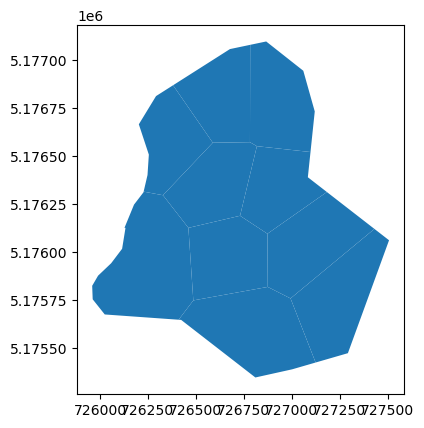

In [18]:
gpd.GeoDataFrame(geometry=gpd.GeoSeries(parts), crs = 26911).plot()

<Axes: >

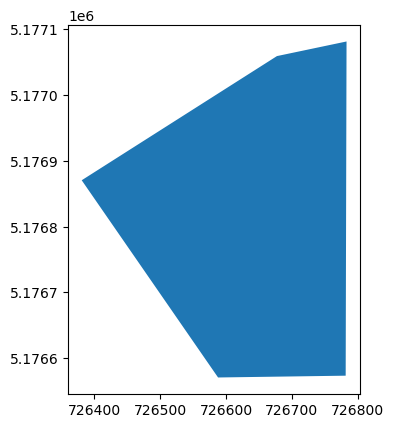

In [19]:
base_poly.plot()

In [20]:
bucket = 'mpg-aerial-survey/supporting_data/testing'
process_images(batch=target_photos, output_bucket=bucket,
                ortho_res=survey_res, cutline=base_poly ,suffix=array_idx,
                gcp_list_path=gcp_list)

# log_progress(f'stopping_{array_idx}.txt', log_bucket)
# shutil.rmtree(temp_work)
# stop_instance(instance_name)

--2023-06-13 22:16:59--  https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612113054_0489_D.JPG
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.33.112, 142.251.215.240, 142.250.69.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.33.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8290304 (7.9M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612113054_0489_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.35M 6s
    50K .......... .......... .......... .......... ..........  1% 2.48M 4s
   100K .......... .......... .......... .......... ..........  1% 3.81M 4s
   150K .......... .......... .......... .......... ..........  2% 5.85M 3s
   200K .......... .......... .......... .......... ..........  3% 5.56M 3s
   250K .......... .......... .......... .......... ..........  3

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612113054_0489_D.JPG


200 OK
Length: 8204288 (7.8M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612113054_0490_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.42M 5s
    50K .......... .......... .......... .......... ..........  1% 2.02M 5s
   100K .......... .......... .......... .......... ..........  1% 1001K 6s
   150K .......... .......... .......... .......... ..........  2% 14.1M 4s
   200K .......... .......... .......... .......... ..........  3% 68.8M 3s
   250K .......... .......... .......... .......... ..........  3% 63.9M 3s
   300K .......... .......... .......... .......... ..........  4% 4.67M 3s
   350K .......... .......... .......... .......... ..........  4% 8.49M 2s
   400K .......... .......... .......... .......... ..........  5%  715K 3s
   450K .......... .......... .......... .......... ..........  6% 20.1M 3s
   500K .......... .......... .......... .......... ..........  6% 73.9M 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612113054_0490_D.JPG


200 OK
Length: 8343552 (8.0M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612113055_0491_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.38M 6s
    50K .......... .......... .......... .......... ..........  1% 2.33M 5s
   100K .......... .......... .......... .......... ..........  1% 3.66M 4s
   150K .......... .......... .......... .......... ..........  2% 4.49M 3s
   200K .......... .......... .......... .......... ..........  3% 4.48M 3s
   250K .......... .......... .......... .......... ..........  3%  744K 4s
   300K .......... .......... .......... .......... ..........  4% 39.2M 4s
   350K .......... .......... .......... .......... ..........  4% 65.8M 3s
   400K .......... .......... .......... .......... ..........  5% 2.91M 3s
   450K .......... .......... .......... .......... ..........  6% 66.8M 3s
   500K .......... .......... .......... .......... ..........  6% 1.27M 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612113055_0491_D.JPG


200 OK
Length: 8503296 (8.1M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612113056_0492_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.46M 6s
    50K .......... .......... .......... .......... ..........  1% 2.39M 4s
   100K .......... .......... .......... .......... ..........  1% 3.94M 4s
   150K .......... .......... .......... .......... ..........  2% 5.11M 3s
   200K .......... .......... .......... .......... ..........  3% 4.92M 3s
   250K .......... .......... .......... .......... ..........  3% 4.71M 3s
   300K .......... .......... .......... .......... ..........  4%  819K 4s
   350K .......... .......... .......... .......... ..........  4% 48.1M 3s
   400K .......... .......... .......... .......... ..........  5% 88.5M 3s
   450K .......... .......... .......... .......... ..........  6% 75.1M 2s
   500K .......... .......... .......... .......... ..........  6% 17.8M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612113056_0492_D.JPG


200 OK
Length: 8523776 (8.1M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612113057_0493_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.52M 5s
    50K .......... .......... .......... .......... ..........  1% 1.94M 5s
   100K .......... .......... .......... .......... ..........  1% 5.04M 4s
   150K .......... .......... .......... .......... ..........  2% 6.01M 3s
   200K .......... .......... .......... .......... ..........  3% 4.70M 3s
   250K .......... .......... .......... .......... ..........  3% 4.34M 3s
   300K .......... .......... .......... .......... ..........  4% 8.25M 2s
   350K .......... .......... .......... .......... ..........  4% 1.33M 3s
   400K .......... .......... .......... .......... ..........  5% 8.89M 3s
   450K .......... .......... .......... .......... ..........  6% 7.95M 2s
   500K .......... .......... .......... .......... ..........  6% 8.55M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612113057_0493_D.JPG


200 OK
Length: 8720384 (8.3M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612113057_0494_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.23M 7s
    50K .......... .......... .......... .......... ..........  1% 2.27M 5s
   100K .......... .......... .......... .......... ..........  1% 4.23M 4s
   150K .......... .......... .......... .......... ..........  2% 1.27M 5s
   200K .......... .......... .......... .......... ..........  2% 54.1M 4s
   250K .......... .......... .......... .......... ..........  3% 37.7M 3s
   300K .......... .......... .......... .......... ..........  4% 10.9M 3s
   350K .......... .......... .......... .......... ..........  4% 3.88M 3s
   400K .......... .......... .......... .......... ..........  5% 5.35M 3s
   450K .......... .......... .......... .......... ..........  5% 1.41M 3s
   500K .......... .......... .......... .......... ..........  6% 5.81M 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612113057_0494_D.JPG


200 OK
Length: 8798208 (8.4M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612113058_0495_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.55M 5s
    50K .......... .......... .......... .......... ..........  1% 2.10M 5s
   100K .......... .......... .......... .......... ..........  1% 2.74M 4s
   150K .......... .......... .......... .......... ..........  2% 5.27M 3s
   200K .......... .......... .......... .......... ..........  2% 4.38M 3s
   250K .......... .......... .......... .......... ..........  3%  561K 5s
   300K .......... .......... .......... .......... ..........  4% 79.5M 4s
   350K .......... .......... .......... .......... ..........  4% 80.3M 4s
   400K .......... .......... .......... .......... ..........  5% 79.1M 3s
   450K .......... .......... .......... .......... ..........  5% 82.3M 3s
   500K .......... .......... .......... .......... ..........  6% 14.7M 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612113058_0495_D.JPG


200 OK
Length: 8781824 (8.4M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612113059_0496_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.56M 5s
    50K .......... .......... .......... .......... ..........  1% 2.04M 5s
   100K .......... .......... .......... .......... ..........  1% 4.78M 4s
   150K .......... .......... .......... .......... ..........  2% 6.19M 3s
   200K .......... .......... .......... .......... ..........  2% 5.01M 3s
   250K .......... .......... .......... .......... ..........  3% 5.70M 3s
   300K .......... .......... .......... .......... ..........  4% 4.37M 2s
   350K .......... .......... .......... .......... ..........  4% 6.91M 2s
   400K .......... .......... .......... .......... ..........  5% 1.35M 3s
   450K .......... .......... .......... .......... ..........  5%  733K 3s
   500K .......... .......... .......... .......... ..........  6%  111M 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612113059_0496_D.JPG


200 OK
Length: 8642560 (8.2M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612113100_0497_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.37M 6s
    50K .......... .......... .......... .......... ..........  1% 1.80M 5s
   100K .......... .......... .......... .......... ..........  1% 4.39M 4s
   150K .......... .......... .......... .......... ..........  2% 3.43M 4s
   200K .......... .......... .......... .......... ..........  2%  706K 5s
   250K .......... .......... .......... .......... ..........  3% 10.8M 4s
   300K .......... .......... .......... .......... ..........  4% 25.8M 4s
   350K .......... .......... .......... .......... ..........  4% 13.8M 3s
   400K .......... .......... .......... .......... ..........  5% 27.0M 3s
   450K .......... .......... .......... .......... ..........  5% 36.8M 3s
   500K .......... .......... .......... .......... ..........  6% 14.2M 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612113100_0497_D.JPG


connected.
HTTP request sent, awaiting response... 200 OK
Length: 8740864 (8.3M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612113100_0498_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.37M 6s
    50K .......... .......... .......... .......... ..........  1% 1.65M 6s
   100K .......... .......... .......... .......... ..........  1% 1.29M 6s
   150K .......... .......... .......... .......... ..........  2% 5.12M 5s
   200K .......... .......... .......... .......... ..........  2% 4.22M 4s
   250K .......... .......... .......... .......... ..........  3% 4.37M 4s
   300K .......... .......... .......... .......... ..........  4% 5.51M 3s
   350K .......... .......... .......... .......... ..........  4%  803K 4s
   400K .......... .......... .......... .......... ..........  5% 29.3M 4s
   450K .......... .......... .......... .......... ..........  5% 49.7M 3s
   500K .......... .......... ....

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612113100_0498_D.JPG


200 OK
Length: 8626176 (8.2M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612113101_0499_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.44M 6s
    50K .......... .......... .......... .......... ..........  1% 2.23M 5s
   100K .......... .......... .......... .......... ..........  1% 3.69M 4s
   150K .......... .......... .......... .......... ..........  2% 3.80M 3s
   200K .......... .......... .......... .......... ..........  2% 55.9M 3s
   250K .......... .......... .......... .......... ..........  3% 5.62M 2s
   300K .......... .......... .......... .......... ..........  4% 4.96M 2s
   350K .......... .......... .......... .......... ..........  4% 5.54M 2s
   400K .......... .......... .......... .......... ..........  5% 1.42M 3s
   450K .......... .......... .......... .......... ..........  5% 4.88M 2s
   500K .......... .......... .......... .......... ..........  6% 55.3M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612113101_0499_D.JPG


200 OK
Length: 8482816 (8.1M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612113102_0500_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.47M 5s
    50K .......... .......... .......... .......... ..........  1% 2.39M 4s
   100K .......... .......... .......... .......... ..........  1% 3.96M 4s
   150K .......... .......... .......... .......... ..........  2% 5.66M 3s
   200K .......... .......... .......... .......... ..........  3% 3.07M 3s
   250K .......... .......... .......... .......... ..........  3% 1.47M 3s
   300K .......... .......... .......... .......... ..........  4% 9.48M 3s
   350K .......... .......... .......... .......... ..........  4% 1.30M 3s
   400K .......... .......... .......... .......... ..........  5% 45.1M 3s
   450K .......... .......... .......... .......... ..........  6% 57.2M 3s
   500K .......... .......... .......... .......... ..........  6% 53.5M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612113102_0500_D.JPG


200 OK
Length: 8441856 (8.1M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612113103_0501_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.51M 5s
    50K .......... .......... .......... .......... ..........  1% 1.92M 5s
   100K .......... .......... .......... .......... ..........  1% 4.43M 4s
   150K .......... .......... .......... .......... ..........  2% 5.39M 3s
   200K .......... .......... .......... .......... ..........  3% 4.48M 3s
   250K .......... .......... .......... .......... ..........  3% 4.89M 3s
   300K .......... .......... .......... .......... ..........  4% 1.19M 3s
   350K .......... .......... .......... .......... ..........  4% 7.72M 3s
   400K .......... .......... .......... .......... ..........  5% 7.32M 3s
   450K .......... .......... .......... .......... ..........  6% 6.12M 2s
   500K .......... .......... .......... .......... ..........  6% 20.0M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612113103_0501_D.JPG


HTTP request sent, awaiting response... 200 OK
Length: 8491008 (8.1M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612113103_0502_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.12M 7s
    50K .......... .......... .......... .......... ..........  1% 1.69M 6s
   100K .......... .......... .......... .......... ..........  1% 5.12M 4s
   150K .......... .......... .......... .......... ..........  2% 5.70M 4s
   200K .......... .......... .......... .......... ..........  3% 3.52M 3s
   250K .......... .......... .......... .......... ..........  3% 2.86M 3s
   300K .......... .......... .......... .......... ..........  4% 1.66M 3s
   350K .......... .......... .......... .......... ..........  4% 5.66M 3s
   400K .......... .......... .......... .......... ..........  5% 10.5M 3s
   450K .......... .......... .......... .......... ..........  6% 1.32M 3s
   500K .......... .......... .......... ....

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612113103_0502_D.JPG


200 OK
Length: 8478720 (8.1M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612113104_0503_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.21M 7s
    50K .......... .......... .......... .......... ..........  1% 2.04M 5s
   100K .......... .......... .......... .......... ..........  1% 4.91M 4s
   150K .......... .......... .......... .......... ..........  2% 3.49M 4s
   200K .......... .......... .......... .......... ..........  3% 8.23M 3s
   250K .......... .......... .......... .......... ..........  3% 4.51M 3s
   300K .......... .......... .......... .......... ..........  4% 6.06M 3s
   350K .......... .......... .......... .......... ..........  4% 6.13M 2s
   400K .......... .......... .......... .......... ..........  5% 1.10M 3s
   450K .......... .......... .......... .......... ..........  6% 17.1M 3s
   500K .......... .......... .......... .......... ..........  6% 31.9M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612113104_0503_D.JPG


200 OK
Length: 8458240 (8.1M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612113105_0504_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.31M 6s
    50K .......... .......... .......... .......... ..........  1% 1.85M 5s
   100K .......... .......... .......... .......... ..........  1% 3.45M 4s
   150K .......... .......... .......... .......... ..........  2% 5.19M 4s
   200K .......... .......... .......... .......... ..........  3% 4.58M 3s
   250K .......... .......... .......... .......... ..........  3% 6.54M 3s
   300K .......... .......... .......... .......... ..........  4% 5.00M 3s
   350K .......... .......... .......... .......... ..........  4% 3.27M 3s
   400K .......... .......... .......... .......... ..........  5% 1.54M 3s
   450K .......... .......... .......... .......... ..........  6% 7.80M 3s
   500K .......... .......... .......... .......... ..........  6% 16.1M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612113105_0504_D.JPG


200 OK
Length: 8396800 (8.0M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612113106_0505_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.23M 6s
    50K .......... .......... .......... .......... ..........  1% 2.03M 5s
   100K .......... .......... .......... .......... ..........  1% 4.56M 4s
   150K .......... .......... .......... .......... ..........  2% 1.21M 5s
   200K .......... .......... .......... .......... ..........  3% 11.4M 4s
   250K .......... .......... .......... .......... ..........  3% 6.00M 3s
   300K .......... .......... .......... .......... ..........  4% 8.76M 3s
   350K .......... .......... .......... .......... ..........  4% 2.99M 3s
   400K .......... .......... .......... .......... ..........  5% 1.14M 3s
   450K .......... .......... .......... .......... ..........  6% 3.80M 3s
   500K .......... .......... .......... .......... ..........  6% 2.41M 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612113106_0505_D.JPG


200 OK
Length: 8351744 (8.0M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612113107_0506_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.43M 6s
    50K .......... .......... .......... .......... ..........  1% 2.19M 5s
   100K .......... .......... .......... .......... ..........  1% 3.80M 4s
   150K .......... .......... .......... .......... ..........  2% 5.96M 3s
   200K .......... .......... .......... .......... ..........  3% 2.70M 3s
   250K .......... .......... .......... .......... ..........  3%  766K 4s
   300K .......... .......... .......... .......... ..........  4% 19.6M 4s
   350K .......... .......... .......... .......... ..........  4% 9.67M 3s
   400K .......... .......... .......... .......... ..........  5% 35.6M 3s
   450K .......... .......... .......... .......... ..........  6% 56.2M 3s
   500K .......... .......... .......... .......... ..........  6% 51.2M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612113107_0506_D.JPG


connected.
HTTP request sent, awaiting response... 200 OK
Length: 7991296 (7.6M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115423_0054_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.45M 5s
    50K .......... .......... .......... .......... ..........  1% 2.18M 4s
   100K .......... .......... .......... .......... ..........  1% 2.53M 4s
   150K .......... .......... .......... .......... ..........  2% 1.21M 4s
   200K .......... .......... .......... .......... ..........  3% 9.98M 4s
   250K .......... .......... .......... .......... ..........  3% 3.74M 3s
   300K .......... .......... .......... .......... ..........  4% 53.4M 3s
   350K .......... .......... .......... .......... ..........  5% 1.42M 3s
   400K .......... .......... .......... .......... ..........  5% 4.47M 3s
   450K .......... .......... .......... .......... ..........  6% 9.32M 3s
   500K .......... .......... ....

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115423_0054_D.JPG


200 OK
Length: 7913472 (7.5M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115424_0055_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.26M 6s
    50K .......... .......... .......... .......... ..........  1% 1.78M 5s
   100K .......... .......... .......... .......... ..........  1% 4.33M 4s
   150K .......... .......... .......... .......... ..........  2% 1.29M 4s
   200K .......... .......... .......... .......... ..........  3% 42.8M 3s
   250K .......... .......... .......... .......... ..........  3% 47.7M 3s
   300K .......... .......... .......... .......... ..........  4% 1.60M 3s
   350K .......... .......... .......... .......... ..........  5% 13.0M 3s
   400K .......... .......... .......... .......... ..........  5% 47.1M 2s
   450K .......... .......... .......... .......... ..........  6% 2.31M 3s
   500K .......... .......... .......... .......... ..........  7% 1.13M 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115424_0055_D.JPG


200 OK
Length: 7892992 (7.5M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115425_0056_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.52M 5s
    50K .......... .......... .......... .......... ..........  1% 2.05M 4s
   100K .......... .......... .......... .......... ..........  1% 3.36M 4s
   150K .......... .......... .......... .......... ..........  2% 6.00M 3s
   200K .......... .......... .......... .......... ..........  3% 3.11M 3s
   250K .......... .......... .......... .......... ..........  3% 1.08M 3s
   300K .......... .......... .......... .......... ..........  4% 19.5M 3s
   350K .......... .......... .......... .......... ..........  5% 16.5M 3s
   400K .......... .......... .......... .......... ..........  5% 11.3M 2s
   450K .......... .......... .......... .......... ..........  6% 10.9M 2s
   500K .......... .......... .......... .......... ..........  7% 42.7M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115425_0056_D.JPG


200 OK
Length: 7884800 (7.5M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115426_0057_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.54M 5s
    50K .......... .......... .......... .......... ..........  1% 1.58M 5s
   100K .......... .......... .......... .......... ..........  1% 6.09M 4s
   150K .......... .......... .......... .......... ..........  2% 3.16M 3s
   200K .......... .......... .......... .......... ..........  3% 1.35M 4s
   250K .......... .......... .......... .......... ..........  3% 13.5M 3s
   300K .......... .......... .......... .......... ..........  4% 6.32M 3s
   350K .......... .......... .......... .......... ..........  5% 13.9M 3s
   400K .......... .......... .......... .......... ..........  5% 27.4M 2s
   450K .......... .......... .......... .......... ..........  6% 9.14M 2s
   500K .......... .......... .......... .......... ..........  7%  767K 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115426_0057_D.JPG


200 OK
Length: 7938048 (7.6M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115427_0058_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.58M 5s
    50K .......... .......... .......... .......... ..........  1% 1.69M 5s
   100K .......... .......... .......... .......... ..........  1% 4.80M 4s
   150K .......... .......... .......... .......... ..........  2% 5.95M 3s
   200K .......... .......... .......... .......... ..........  3% 3.89M 3s
   250K .......... .......... .......... .......... ..........  3% 6.51M 2s
   300K .......... .......... .......... .......... ..........  4% 5.41M 2s
   350K .......... .......... .......... .......... ..........  5% 1.33M 3s
   400K .......... .......... .......... .......... ..........  5% 6.49M 2s
   450K .......... .......... .......... .......... ..........  6% 18.2M 2s
   500K .......... .......... .......... .......... ..........  7% 11.7M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115427_0058_D.JPG


200 OK
Length: 7897088 (7.5M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115427_0059_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.47M 5s
    50K .......... .......... .......... .......... ..........  1% 2.07M 4s
   100K .......... .......... .......... .......... ..........  1% 4.80M 3s
   150K .......... .......... .......... .......... ..........  2% 5.44M 3s
   200K .......... .......... .......... .......... ..........  3% 3.51M 3s
   250K .......... .......... .......... .......... ..........  3% 8.73M 2s
   300K .......... .......... .......... .......... ..........  4%  703K 4s
   350K .......... .......... .......... .......... ..........  5% 60.9M 3s
   400K .......... .......... .......... .......... ..........  5% 55.0M 3s
   450K .......... .......... .......... .......... ..........  6% 59.3M 2s
   500K .......... .......... .......... .......... ..........  7% 43.3M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115427_0059_D.JPG


200 OK
Length: 7872512 (7.5M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115428_0060_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.34M 6s
    50K .......... .......... .......... .......... ..........  1% 1.82M 5s
   100K .......... .......... .......... .......... ..........  1% 4.28M 4s
   150K .......... .......... .......... .......... ..........  2% 2.98M 3s
   200K .......... .......... .......... .......... ..........  3% 6.38M 3s
   250K .......... .......... .......... .......... ..........  3%  709K 4s
   300K .......... .......... .......... .......... ..........  4% 25.7M 4s
   350K .......... .......... .......... .......... ..........  5% 29.3M 3s
   400K .......... .......... .......... .......... ..........  5% 19.7M 3s
   450K .......... .......... .......... .......... ..........  6% 27.3M 3s
   500K .......... .......... .......... .......... ..........  7% 1.77M 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115428_0060_D.JPG


200 OK
Length: 8060928 (7.7M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115429_0061_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.39M 5s
    50K .......... .......... .......... .......... ..........  1% 1.44M 5s
   100K .......... .......... .......... .......... ..........  1% 2.45M 5s
   150K .......... .......... .......... .......... ..........  2% 3.18M 4s
   200K .......... .......... .......... .......... ..........  3% 1.40M 4s
   250K .......... .......... .......... .......... ..........  3% 11.8M 4s
   300K .......... .......... .......... .......... ..........  4% 6.28M 3s
   350K .......... .......... .......... .......... ..........  5% 5.55M 3s
   400K .......... .......... .......... .......... ..........  5% 10.3M 3s
   450K .......... .......... .......... .......... ..........  6%  809K 3s
   500K .......... .......... .......... .......... ..........  6% 22.6M 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115429_0061_D.JPG


200 OK
Length: 8024064 (7.7M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115430_0062_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.37M 6s
    50K .......... .......... .......... .......... ..........  1% 2.35M 4s
   100K .......... .......... .......... .......... ..........  1% 4.47M 3s
   150K .......... .......... .......... .......... ..........  2% 5.77M 3s
   200K .......... .......... .......... .......... ..........  3% 6.54M 3s
   250K .......... .......... .......... .......... ..........  3% 4.68M 2s
   300K .......... .......... .......... .......... ..........  4% 5.60M 2s
   350K .......... .......... .......... .......... ..........  5% 6.71M 2s
   400K .......... .......... .......... .......... ..........  5% 1.27M 2s
   450K .......... .......... .......... .......... ..........  6% 5.13M 2s
   500K .......... .......... .......... .......... ..........  7% 16.5M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115430_0062_D.JPG


Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.217.112, 142.250.217.80, 142.251.215.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.217.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7995392 (7.6M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115430_0063_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.48M 5s
    50K .......... .......... .......... .......... ..........  1% 2.29M 4s
   100K .......... .......... .......... .......... ..........  1% 4.25M 3s
   150K .......... .......... .......... .......... ..........  2% 6.33M 3s
   200K .......... .......... .......... .......... ..........  3% 5.67M 2s
   250K .......... .......... .......... .......... ..........  3% 5.16M 2s
   300K .......... .......... .......... .......... ..........  4% 4.83M 2s
   350K .......... .......... .......... .......... .........

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115430_0063_D.JPG


200 OK
Length: 8183808 (7.8M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115431_0064_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.45M 5s
    50K .......... .......... .......... .......... ..........  1% 2.07M 5s
   100K .......... .......... .......... .......... ..........  1% 3.96M 4s
   150K .......... .......... .......... .......... ..........  2% 3.96M 3s
   200K .......... .......... .......... .......... ..........  3% 1.22M 4s
   250K .......... .......... .......... .......... ..........  3% 8.79M 3s
   300K .......... .......... .......... .......... ..........  4% 1.45M 4s
   350K .......... .......... .......... .......... ..........  5% 62.0M 3s
   400K .......... .......... .......... .......... ..........  5% 55.4M 3s
   450K .......... .......... .......... .......... ..........  6% 50.5M 2s
   500K .......... .......... .......... .......... ..........  6% 40.5M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115431_0064_D.JPG


200 OK
Length: 8351744 (8.0M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115432_0065_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.29M 6s
    50K .......... .......... .......... .......... ..........  1% 2.15M 5s
   100K .......... .......... .......... .......... ..........  1% 2.46M 4s
   150K .......... .......... .......... .......... ..........  2% 4.21M 4s
   200K .......... .......... .......... .......... ..........  3% 1.42M 4s
   250K .......... .......... .......... .......... ..........  3% 30.4M 3s
   300K .......... .......... .......... .......... ..........  4% 29.6M 3s
   350K .......... .......... .......... .......... ..........  4% 6.57M 3s
   400K .......... .......... .......... .......... ..........  5% 3.86M 3s
   450K .......... .......... .......... .......... ..........  6% 1.37M 3s
   500K .......... .......... .......... .......... ..........  6% 1.20M 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115432_0065_D.JPG


200 OK
Length: 8462336 (8.1M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115433_0066_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.39M 6s
    50K .......... .......... .......... .......... ..........  1% 1.75M 5s
   100K .......... .......... .......... .......... ..........  1% 3.91M 4s
   150K .......... .......... .......... .......... ..........  2% 5.26M 3s
   200K .......... .......... .......... .......... ..........  3% 3.11M 3s
   250K .......... .......... .......... .......... ..........  3% 12.7M 3s
   300K .......... .......... .......... .......... ..........  4% 5.52M 3s
   350K .......... .......... .......... .......... ..........  4%  868K 3s
   400K .......... .......... .......... .......... ..........  5% 49.4M 3s
   450K .......... .......... .......... .......... ..........  6% 36.4M 3s
   500K .......... .......... .......... .......... ..........  6% 38.2M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115433_0066_D.JPG


--2023-06-13 22:18:05--  https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115433_0067_D.JPG
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.217.112, 142.250.217.80, 142.251.215.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.217.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8417280 (8.0M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115433_0067_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.38M 6s
    50K .......... .......... .......... .......... ..........  1% 2.35M 5s
   100K .......... .......... .......... .......... ..........  1% 3.57M 4s
   150K .......... .......... .......... .......... ..........  2% 6.09M 3s
   200K .......... .......... .......... .......... ..........  3% 4.76M 3s
   250K .......... .......... .......... .......... .......... 

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115433_0067_D.JPG


200 OK
Length: 8400896 (8.0M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115434_0068_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.32M 6s
    50K .......... .......... .......... .......... ..........  1% 2.01M 5s
   100K .......... .......... .......... .......... ..........  1% 2.85M 4s
   150K .......... .......... .......... .......... ..........  2% 6.33M 3s
   200K .......... .......... .......... .......... ..........  3% 3.65M 3s
   250K .......... .......... .......... .......... ..........  3%  790K 4s
   300K .......... .......... .......... .......... ..........  4% 53.7M 4s
   350K .......... .......... .......... .......... ..........  4% 43.4M 3s
   400K .......... .......... .......... .......... ..........  5% 47.3M 3s
   450K .......... .......... .......... .......... ..........  6% 43.1M 3s
   500K .......... .......... .......... .......... ..........  6% 38.4M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115434_0068_D.JPG


200 OK
Length: 8531968 (8.1M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115435_0069_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.46M 6s
    50K .......... .......... .......... .......... ..........  1% 1.88M 5s
   100K .......... .......... .......... .......... ..........  1% 4.11M 4s
   150K .......... .......... .......... .......... ..........  2% 3.34M 3s
   200K .......... .......... .......... .......... ..........  3% 1.32M 4s
   250K .......... .......... .......... .......... ..........  3% 4.22M 4s
   300K .......... .......... .......... .......... ..........  4% 27.1M 3s
   350K .......... .......... .......... .......... ..........  4% 5.33M 3s
   400K .......... .......... .......... .......... ..........  5% 7.10M 3s
   450K .......... .......... .......... .......... ..........  6% 21.0M 2s
   500K .......... .......... .......... .......... ..........  6% 12.5M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115435_0069_D.JPG


200 OK
Length: 8564736 (8.2M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115436_0070_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.50M 5s
    50K .......... .......... .......... .......... ..........  1% 1.41M 6s
   100K .......... .......... .......... .......... ..........  1% 4.65M 4s
   150K .......... .......... .......... .......... ..........  2% 3.98M 4s
   200K .......... .......... .......... .......... ..........  2% 1.17M 4s
   250K .......... .......... .......... .......... ..........  3% 27.8M 4s
   300K .......... .......... .......... .......... ..........  4% 6.18M 3s
   350K .......... .......... .......... .......... ..........  4% 33.6M 3s
   400K .......... .......... .......... .......... ..........  5% 1.22M 3s
   450K .......... .......... .......... .......... ..........  5% 23.9M 3s
   500K .......... .......... .......... .......... ..........  6% 6.50M 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115436_0070_D.JPG


200 OK
Length: 8609792 (8.2M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115436_0071_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.43M 6s
    50K .......... .......... .......... .......... ..........  1% 1.51M 6s
   100K .......... .......... .......... .......... ..........  1% 4.59M 4s
   150K .......... .......... .......... .......... ..........  2% 3.21M 4s
   200K .......... .......... .......... .......... ..........  2%  751K 5s
   250K .......... .......... .......... .......... ..........  3% 55.7M 4s
   300K .......... .......... .......... .......... ..........  4% 54.7M 4s
   350K .......... .......... .......... .......... ..........  4% 58.5M 3s
   400K .......... .......... .......... .......... ..........  5% 31.1M 3s
   450K .......... .......... .......... .......... ..........  5% 1.51M 3s
   500K .......... .......... .......... .......... ..........  6% 5.52M 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115436_0071_D.JPG


200 OK
Length: 8466432 (8.1M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115437_0072_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.51M 5s
    50K .......... .......... .......... .......... ..........  1% 1.96M 5s
   100K .......... .......... .......... .......... ..........  1% 3.55M 4s
   150K .......... .......... .......... .......... ..........  2% 5.65M 3s
   200K .......... .......... .......... .......... ..........  3% 4.34M 3s
   250K .......... .......... .......... .......... ..........  3% 3.73M 3s
   300K .......... .......... .......... .......... ..........  4% 1.34M 3s
   350K .......... .......... .......... .......... ..........  4% 8.21M 3s
   400K .......... .......... .......... .......... ..........  5% 1.35M 3s
   450K .......... .......... .......... .......... ..........  6% 1.49M 3s
   500K .......... .......... .......... .......... ..........  6% 27.8M 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115437_0072_D.JPG


200 OK
Length: 8507392 (8.1M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115438_0073_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.44M 6s
    50K .......... .......... .......... .......... ..........  1% 2.09M 5s
   100K .......... .......... .......... .......... ..........  1% 3.70M 4s
   150K .......... .......... .......... .......... ..........  2% 6.24M 3s
   200K .......... .......... .......... .......... ..........  3% 4.71M 3s
   250K .......... .......... .......... .......... ..........  3% 5.88M 3s
   300K .......... .......... .......... .......... ..........  4% 1.22M 3s
   350K .......... .......... .......... .......... ..........  4% 1.57M 3s
   400K .......... .......... .......... .......... ..........  5% 21.0M 3s
   450K .......... .......... .......... .......... ..........  6% 22.8M 3s
   500K .......... .......... .......... .......... ..........  6% 30.0M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115438_0073_D.JPG


connected.
HTTP request sent, awaiting response... 200 OK
Length: 8314880 (7.9M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115439_0074_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.50M 5s
    50K .......... .......... .......... .......... ..........  1% 1.68M 5s
   100K .......... .......... .......... .......... ..........  1% 4.20M 4s
   150K .......... .......... .......... .......... ..........  2% 5.94M 3s
   200K .......... .......... .......... .......... ..........  3% 3.99M 3s
   250K .......... .......... .......... .......... ..........  3%  656K 4s
   300K .......... .......... .......... .......... ..........  4% 24.6M 4s
   350K .......... .......... .......... .......... ..........  4%  568K 5s
   400K .......... .......... .......... .......... ..........  5% 24.6M 4s
   450K .......... .......... .......... .......... ..........  6% 27.2M 4s
   500K .......... .......... ....

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115439_0074_D.JPG


200 OK
Length: 8253440 (7.9M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115439_0075_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.31M 6s
    50K .......... .......... .......... .......... ..........  1% 2.21M 5s
   100K .......... .......... .......... .......... ..........  1% 4.70M 4s
   150K .......... .......... .......... .......... ..........  2% 3.86M 3s
   200K .......... .......... .......... .......... ..........  3% 1.26M 4s
   250K .......... .......... .......... .......... ..........  3% 4.75M 3s
   300K .......... .......... .......... .......... ..........  4% 47.6M 3s
   350K .......... .......... .......... .......... ..........  4% 5.59M 3s
   400K .......... .......... .......... .......... ..........  5% 31.2M 2s
   450K .......... .......... .......... .......... ..........  6% 2.91M 2s
   500K .......... .......... .......... .......... ..........  6% 1.56M 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115439_0075_D.JPG


--2023-06-13 22:18:25--  https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115440_0076_D.JPG
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.217.112, 142.250.217.80, 142.251.215.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.217.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8155136 (7.8M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115440_0076_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.60M 5s
    50K .......... .......... .......... .......... ..........  1% 1.90M 4s
   100K .......... .......... .......... .......... ..........  1% 2.66M 4s
   150K .......... .......... .......... .......... ..........  2% 3.46M 3s
   200K .......... .......... .......... .......... ..........  3% 1.31M 4s
   250K .......... .......... .......... .......... .......... 

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115440_0076_D.JPG


142.250.217.112, 142.250.217.80, 142.251.215.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.217.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7962624 (7.6M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115441_0077_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.50M 5s
    50K .......... .......... .......... .......... ..........  1% 2.24M 4s
   100K .......... .......... .......... .......... ..........  1% 3.20M 4s
   150K .......... .......... .......... .......... ..........  2% 5.12M 3s
   200K .......... .......... .......... .......... ..........  3% 1.42M 3s
   250K .......... .......... .......... .......... ..........  3% 32.1M 3s
   300K .......... .......... .......... .......... ..........  4% 2.77M 3s
   350K .......... .......... .......... .......... ..........  5% 11.2M 3s
   400K .......... .......... .......... .....

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115441_0077_D.JPG


HTTP request sent, awaiting response... 200 OK
Length: 7958528 (7.6M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115442_0078_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.04M 7s
    50K .......... .......... .......... .......... ..........  1% 4.24M 4s
   100K .......... .......... .......... .......... ..........  1% 2.90M 4s
   150K .......... .......... .......... .......... ..........  2% 1.20M 4s
   200K .......... .......... .......... .......... ..........  3% 3.89M 4s
   250K .......... .......... .......... .......... ..........  3% 25.2M 3s
   300K .......... .......... .......... .......... ..........  4% 3.60M 3s
   350K .......... .......... .......... .......... ..........  5% 25.1M 3s
   400K .......... .......... .......... .......... ..........  5% 1.54M 3s
   450K .......... .......... .......... .......... ..........  6% 1.79M 3s
   500K .......... .......... .......... ....

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115442_0078_D.JPG


--2023-06-13 22:18:31--  https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115442_0079_D.JPG
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.217.112, 142.250.217.80, 142.251.215.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.217.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7811072 (7.4M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115442_0079_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.32M 6s
    50K .......... .......... .......... .......... ..........  1% 2.69M 4s
   100K .......... .......... .......... .......... ..........  1% 3.91M 3s
   150K .......... .......... .......... .......... ..........  2% 4.68M 3s
   200K .......... .......... .......... .......... ..........  3% 4.16M 3s
   250K .......... .......... .......... .......... .......... 

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115442_0079_D.JPG


Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.217.112, 142.250.217.80, 142.251.215.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.217.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7757824 (7.4M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115443_0080_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.52M 5s
    50K .......... .......... .......... .......... ..........  1% 1.93M 4s
   100K .......... .......... .......... .......... ..........  1% 4.30M 3s
   150K .......... .......... .......... .......... ..........  2% 4.64M 3s
   200K .......... .......... .......... .......... ..........  3% 3.86M 3s
   250K .......... .......... .......... .......... ..........  3%  791K 4s
   300K .......... .......... .......... .......... ..........  4% 25.6M 3s
   350K .......... .......... .......... .......... .........

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115443_0080_D.JPG


connected.
HTTP request sent, awaiting response... 200 OK
Length: 7766016 (7.4M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115444_0081_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.52M 5s
    50K .......... .......... .......... .......... ..........  1% 2.39M 4s
   100K .......... .......... .......... .......... ..........  1% 3.59M 3s
   150K .......... .......... .......... .......... ..........  2% 6.16M 3s
   200K .......... .......... .......... .......... ..........  3% 5.76M 2s
   250K .......... .......... .......... .......... ..........  3% 5.23M 2s
   300K .......... .......... .......... .......... ..........  4% 4.94M 2s
   350K .......... .......... .......... .......... ..........  5% 1.20M 3s
   400K .......... .......... .......... .......... ..........  5%  742K 3s
   450K .......... .......... .......... .......... ..........  6% 26.9M 3s
   500K .......... .......... ....

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115444_0081_D.JPG


Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.217.112, 142.250.217.80, 142.251.215.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.217.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7974912 (7.6M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115445_0082_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.42M 5s
    50K .......... .......... .......... .......... ..........  1% 2.19M 4s
   100K .......... .......... .......... .......... ..........  1% 4.00M 4s
   150K .......... .......... .......... .......... ..........  2% 5.50M 3s
   200K .......... .......... .......... .......... ..........  3% 4.44M 3s
   250K .......... .......... .......... .......... ..........  3% 5.78M 2s
   300K .......... .......... .......... .......... ..........  4% 1.34M 3s
   350K .......... .......... .......... .......... .........

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115445_0082_D.JPG


200 OK
Length: 8060928 (7.7M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115446_0083_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.36M 6s
    50K .......... .......... .......... .......... ..........  1% 2.13M 5s
   100K .......... .......... .......... .......... ..........  1% 4.08M 4s
   150K .......... .......... .......... .......... ..........  2% 4.11M 3s
   200K .......... .......... .......... .......... ..........  3% 4.03M 3s
   250K .......... .......... .......... .......... ..........  3% 7.83M 3s
   300K .......... .......... .......... .......... ..........  4% 5.80M 2s
   350K .......... .......... .......... .......... ..........  5% 4.57M 2s
   400K .......... .......... .......... .......... ..........  5%  773K 3s
   450K .......... .......... .......... .......... ..........  6% 11.4M 3s
   500K .......... .......... .......... .......... ..........  6% 26.5M 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115446_0083_D.JPG


--2023-06-13 22:18:41--  https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115446_0084_D.JPG
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.217.112, 142.250.217.80, 142.251.215.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.217.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7958528 (7.6M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115446_0084_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.43M 5s
    50K .......... .......... .......... .......... ..........  1% 1.87M 5s
   100K .......... .......... .......... .......... ..........  1% 4.94M 4s
   150K .......... .......... .......... .......... ..........  2% 7.28M 3s
   200K .......... .......... .......... .......... ..........  3% 4.49M 3s
   250K .......... .......... .......... .......... .......... 

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115446_0084_D.JPG


200 OK
Length: 8036352 (7.7M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115447_0085_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.35M 6s
    50K .......... .......... .......... .......... ..........  1% 2.13M 5s
   100K .......... .......... .......... .......... ..........  1% 4.75M 4s
   150K .......... .......... .......... .......... ..........  2% 2.77M 3s
   200K .......... .......... .......... .......... ..........  3% 5.56M 3s
   250K .......... .......... .......... .......... ..........  3% 1.22M 3s
   300K .......... .......... .......... .......... ..........  4% 7.11M 3s
   350K .......... .......... .......... .......... ..........  5% 6.67M 3s
   400K .......... .......... .......... .......... ..........  5%  639K 4s
   450K .......... .......... .......... .......... ..........  6% 59.0M 3s
   500K .......... .......... .......... .......... ..........  7% 63.6M 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115447_0085_D.JPG


200 OK
Length: 7921664 (7.6M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115448_0086_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.27M 6s
    50K .......... .......... .......... .......... ..........  1% 2.29M 5s
   100K .......... .......... .......... .......... ..........  1% 4.33M 4s
   150K .......... .......... .......... .......... ..........  2% 5.14M 3s
   200K .......... .......... .......... .......... ..........  3% 5.61M 3s
   250K .......... .......... .......... .......... ..........  3% 4.54M 2s
   300K .......... .......... .......... .......... ..........  4% 5.55M 2s
   350K .......... .......... .......... .......... ..........  5% 1.46M 3s
   400K .......... .......... .......... .......... ..........  5% 5.00M 2s
   450K .......... .......... .......... .......... ..........  6% 17.9M 2s
   500K .......... .......... .......... .......... ..........  7% 12.9M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115448_0086_D.JPG


--2023-06-13 22:18:47--  https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115449_0087_D.JPG
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.217.112, 142.250.217.80, 142.251.215.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.217.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7983104 (7.6M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115449_0087_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.41M 5s
    50K .......... .......... .......... .......... ..........  1% 2.86M 4s
   100K .......... .......... .......... .......... ..........  1% 3.74M 3s
   150K .......... .......... .......... .......... ..........  2% 4.93M 3s
   200K .......... .......... .......... .......... ..........  3% 5.10M 3s
   250K .......... .......... .......... .......... .......... 

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115449_0087_D.JPG


200 OK
Length: 7995392 (7.6M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115449_0088_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.43M 5s
    50K .......... .......... .......... .......... ..........  1% 1.67M 5s
   100K .......... .......... .......... .......... ..........  1% 4.56M 4s
   150K .......... .......... .......... .......... ..........  2% 4.50M 3s
   200K .......... .......... .......... .......... ..........  3% 5.47M 3s
   250K .......... .......... .......... .......... ..........  3% 4.51M 3s
   300K .......... .......... .......... .......... ..........  4% 1.42M 3s
   350K .......... .......... .......... .......... ..........  5% 4.19M 3s
   400K .......... .......... .......... .......... ..........  5% 8.18M 3s
   450K .......... .......... .......... .......... ..........  6% 3.89M 2s
   500K .......... .......... .......... .......... ..........  7% 38.4M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115449_0088_D.JPG


HTTP request sent, awaiting response... 200 OK
Length: 8089600 (7.7M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115450_0089_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.54M 5s
    50K .......... .......... .......... .......... ..........  1% 1.04M 6s
   100K .......... .......... .......... .......... ..........  1% 25.9M 4s
   150K .......... .......... .......... .......... ..........  2% 1.00M 5s
   200K .......... .......... .......... .......... ..........  3% 23.5M 4s
   250K .......... .......... .......... .......... ..........  3% 27.4M 3s
   300K .......... .......... .......... .......... ..........  4%  766K 4s
   350K .......... .......... .......... .......... ..........  5% 28.8M 4s
   400K .......... .......... .......... .......... ..........  5% 28.8M 3s
   450K .......... .......... .......... .......... ..........  6% 30.8M 3s
   500K .......... .......... .......... ....

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115450_0089_D.JPG


HTTP request sent, awaiting response... 200 OK
Length: 8118272 (7.7M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115738_0310_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.34M 6s
    50K .......... .......... .......... .......... ..........  1% 2.04M 5s
   100K .......... .......... .......... .......... ..........  1% 4.03M 4s
   150K .......... .......... .......... .......... ..........  2% 5.54M 3s
   200K .......... .......... .......... .......... ..........  3% 3.24M 3s
   250K .......... .......... .......... .......... ..........  3% 1.36M 3s
   300K .......... .......... .......... .......... ..........  4% 5.81M 3s
   350K .......... .......... .......... .......... ..........  5% 5.13M 3s
   400K .......... .......... .......... .......... ..........  5%  799K 4s
   450K .......... .......... .......... .......... ..........  6% 19.1M 3s
   500K .......... .......... .......... ....

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115738_0310_D.JPG


Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.217.112, 142.250.217.80, 142.251.215.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.217.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8089600 (7.7M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115739_0311_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.40M 5s
    50K .......... .......... .......... .......... ..........  1% 2.25M 4s
   100K .......... .......... .......... .......... ..........  1% 6.91M 3s
   150K .......... .......... .......... .......... ..........  2% 3.72M 3s
   200K .......... .......... .......... .......... ..........  3% 6.99M 3s
   250K .......... .......... .......... .......... ..........  3% 5.98M 2s
   300K .......... .......... .......... .......... ..........  4% 5.11M 2s
   350K .......... .......... .......... .......... .........

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115739_0311_D.JPG


200 OK
Length: 8105984 (7.7M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115740_0312_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.41M 5s
    50K .......... .......... .......... .......... ..........  1% 2.19M 4s
   100K .......... .......... .......... .......... ..........  1% 4.81M 3s
   150K .......... .......... .......... .......... ..........  2% 6.31M 3s
   200K .......... .......... .......... .......... ..........  3% 4.46M 3s
   250K .......... .......... .......... .......... ..........  3% 5.72M 2s
   300K .......... .......... .......... .......... ..........  4% 4.52M 2s
   350K .......... .......... .......... .......... ..........  5% 1.35M 3s
   400K .......... .......... .......... .......... ..........  5% 8.84M 2s
   450K .......... .......... .......... .......... ..........  6% 28.7M 2s
   500K .......... .......... .......... .......... ..........  6% 9.62M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115740_0312_D.JPG


--2023-06-13 22:18:59--  https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115740_0313_D.JPG
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.217.112, 142.250.217.80, 142.251.215.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.217.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8081408 (7.7M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115740_0313_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.47M 5s
    50K .......... .......... .......... .......... ..........  1% 1.98M 5s
   100K .......... .......... .......... .......... ..........  1% 4.40M 4s
   150K .......... .......... .......... .......... ..........  2% 5.22M 3s
   200K .......... .......... .......... .......... ..........  3% 4.68M 3s
   250K .......... .......... .......... .......... .......... 

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115740_0313_D.JPG


--2023-06-13 22:19:01--  https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115741_0314_D.JPG
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.217.112, 142.250.217.80, 142.251.215.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.217.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8110080 (7.7M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115741_0314_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.30M 6s
    50K .......... .......... .......... .......... ..........  1% 2.13M 5s
   100K .......... .......... .......... .......... ..........  1% 3.54M 4s
   150K .......... .......... .......... .......... ..........  2% 4.55M 3s
   200K .......... .......... .......... .......... ..........  3% 8.17M 3s
   250K .......... .......... .......... .......... .......... 

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115741_0314_D.JPG


200 OK
Length: 8101888 (7.7M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115742_0315_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.34M 6s
    50K .......... .......... .......... .......... ..........  1% 1.72M 5s
   100K .......... .......... .......... .......... ..........  1% 3.46M 4s
   150K .......... .......... .......... .......... ..........  2% 6.41M 3s
   200K .......... .......... .......... .......... ..........  3% 4.04M 3s
   250K .......... .......... .......... .......... ..........  3% 9.10M 3s
   300K .......... .......... .......... .......... ..........  4% 5.31M 2s
   350K .......... .......... .......... .......... ..........  5% 5.21M 2s
   400K .......... .......... .......... .......... ..........  5% 1.31M 3s
   450K .......... .......... .......... .......... ..........  6% 6.54M 2s
   500K .......... .......... .......... .......... ..........  6%  836K 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115742_0315_D.JPG


200 OK
Length: 8163328 (7.8M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115743_0316_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.47M 5s
    50K .......... .......... .......... .......... ..........  1% 2.09M 4s
   100K .......... .......... .......... .......... ..........  1% 3.31M 4s
   150K .......... .......... .......... .......... ..........  2% 4.02M 3s
   200K .......... .......... .......... .......... ..........  3% 3.86M 3s
   250K .......... .......... .......... .......... ..........  3% 1.21M 3s
   300K .......... .......... .......... .......... ..........  4% 7.63M 3s
   350K .......... .......... .......... .......... ..........  5% 5.86M 3s
   400K .......... .......... .......... .......... ..........  5% 7.38M 3s
   450K .......... .......... .......... .......... ..........  6% 6.89M 2s
   500K .......... .......... .......... .......... ..........  6% 1.53M 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115743_0316_D.JPG


200 OK
Length: 8200192 (7.8M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115743_0317_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.50M 5s
    50K .......... .......... .......... .......... ..........  1% 1.63M 5s
   100K .......... .......... .......... .......... ..........  1% 3.22M 4s
   150K .......... .......... .......... .......... ..........  2% 3.52M 4s
   200K .......... .......... .......... .......... ..........  3% 6.36M 3s
   250K .......... .......... .......... .......... ..........  3%  444K 5s
   300K .......... .......... .......... .......... ..........  4% 42.7M 5s
   350K .......... .......... .......... .......... ..........  4% 15.7M 4s
   400K .......... .......... .......... .......... ..........  5% 42.4M 4s
   450K .......... .......... .......... .......... ..........  6% 32.5M 3s
   500K .......... .......... .......... .......... ..........  6% 52.8M 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115743_0317_D.JPG


200 OK
Length: 7966720 (7.6M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115744_0318_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.38M 5s
    50K .......... .......... .......... .......... ..........  1% 2.12M 4s
   100K .......... .......... .......... .......... ..........  1% 3.86M 4s
   150K .......... .......... .......... .......... ..........  2% 4.60M 3s
   200K .......... .......... .......... .......... ..........  3% 3.99M 3s
   250K .......... .......... .......... .......... ..........  3%  559K 5s
   300K .......... .......... .......... .......... ..........  4% 37.9M 4s
   350K .......... .......... .......... .......... ..........  5% 38.8M 3s
   400K .......... .......... .......... .......... ..........  5% 48.8M 3s
   450K .......... .......... .......... .......... ..........  6% 58.4M 3s
   500K .......... .......... .......... .......... ..........  7% 40.9M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115744_0318_D.JPG


HTTP request sent, awaiting response... 200 OK
Length: 7913472 (7.5M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115745_0319_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.67M 4s
    50K .......... .......... .......... .......... ..........  1% 2.49M 4s
   100K .......... .......... .......... .......... ..........  1% 3.85M 3s
   150K .......... .......... .......... .......... ..........  2% 5.05M 3s
   200K .......... .......... .......... .......... ..........  3% 5.49M 2s
   250K .......... .......... .......... .......... ..........  3% 7.00M 2s
   300K .......... .......... .......... .......... ..........  4% 4.99M 2s
   350K .......... .......... .......... .......... ..........  5% 1.41M 2s
   400K .......... .......... .......... .......... ..........  5% 5.38M 2s
   450K .......... .......... .......... .......... ..........  6% 1.73M 2s
   500K .......... .......... .......... ....

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115745_0319_D.JPG


--2023-06-13 22:19:13--  https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115746_0320_D.JPG
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.217.112, 142.250.217.80, 142.251.215.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.217.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7876608 (7.5M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115746_0320_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.07M 7s
    50K .......... .......... .......... .......... ..........  1% 2.30M 5s
   100K .......... .......... .......... .......... ..........  1%  970K 6s
   150K .......... .......... .......... .......... ..........  2% 23.4M 5s
   200K .......... .......... .......... .......... ..........  3% 22.0M 4s
   250K .......... .......... .......... .......... .......... 

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115746_0320_D.JPG


--2023-06-13 22:19:15--  https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115746_0321_D.JPG
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.217.112, 142.250.217.80, 142.251.215.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.217.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7843840 (7.5M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115746_0321_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.55M 5s
    50K .......... .......... .......... .......... ..........  1% 2.20M 4s
   100K .......... .......... .......... .......... ..........  1% 5.10M 3s
   150K .......... .......... .......... .......... ..........  2% 5.22M 3s
   200K .......... .......... .......... .......... ..........  3% 4.06M 3s
   250K .......... .......... .......... .......... .......... 

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115746_0321_D.JPG


200 OK
Length: 7819264 (7.5M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115747_0322_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.41M 5s
    50K .......... .......... .......... .......... ..........  1% 2.28M 4s
   100K .......... .......... .......... .......... ..........  1% 3.44M 4s
   150K .......... .......... .......... .......... ..........  2% 6.43M 3s
   200K .......... .......... .......... .......... ..........  3% 5.05M 3s
   250K .......... .......... .......... .......... ..........  3% 5.40M 2s
   300K .......... .......... .......... .......... ..........  4% 7.13M 2s
   350K .......... .......... .......... .......... ..........  5%  845K 3s
   400K .......... .......... .......... .......... ..........  5% 56.5M 3s
   450K .......... .......... .......... .......... ..........  6% 61.2M 2s
   500K .......... .......... .......... .......... ..........  7% 58.8M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115747_0322_D.JPG


--2023-06-13 22:19:18--  https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115748_0323_D.JPG
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.217.112, 142.250.217.80, 142.251.215.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.217.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7839744 (7.5M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115748_0323_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.46M 5s
    50K .......... .......... .......... .......... ..........  1% 1.63M 5s
   100K .......... .......... .......... .......... ..........  1% 3.92M 4s
   150K .......... .......... .......... .......... ..........  2% 5.18M 3s
   200K .......... .......... .......... .......... ..........  3% 6.58M 3s
   250K .......... .......... .......... .......... .......... 

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115748_0323_D.JPG


200 OK
Length: 7979008 (7.6M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115749_0324_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.38M 5s
    50K .......... .......... .......... .......... ..........  1% 2.52M 4s
   100K .......... .......... .......... .......... ..........  1% 3.99M 3s
   150K .......... .......... .......... .......... ..........  2% 6.25M 3s
   200K .......... .......... .......... .......... ..........  3% 3.36M 3s
   250K .......... .......... .......... .......... ..........  3% 1.23M 3s
   300K .......... .......... .......... .......... ..........  4% 21.8M 3s
   350K .......... .......... .......... .......... ..........  5% 51.8M 2s
   400K .......... .......... .......... .......... ..........  5%  773K 3s
   450K .......... .......... .......... .......... ..........  6% 29.0M 3s
   500K .......... .......... .......... .......... ..........  7% 29.2M 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115749_0324_D.JPG


connected.
HTTP request sent, awaiting response... 200 OK
Length: 8134656 (7.8M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115749_0325_D.JPG’

     0K .......... .......... .......... .......... ..........  0%  466K 17s
    50K .......... .......... .......... .......... ..........  1% 3.23M 10s
   100K .......... .......... .......... .......... ..........  1% 2.28M 7s
   150K .......... .......... .......... .......... ..........  2% 2.50M 6s
   200K .......... .......... .......... .......... ..........  3% 4.30M 5s
   250K .......... .......... .......... .......... ..........  3% 4.99M 5s
   300K .......... .......... .......... .......... ..........  4% 2.73M 4s
   350K .......... .......... .......... .......... ..........  5%  289K 7s
   400K .......... .......... .......... .......... ..........  5% 29.4M 6s
   450K .......... .......... .......... .......... ..........  6% 31.2M 6s
   500K .......... .......... ..

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115749_0325_D.JPG


--2023-06-13 22:19:24--  https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115750_0326_D.JPG
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.217.112, 142.250.217.80, 142.251.215.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.217.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8171520 (7.8M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115750_0326_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.23M 6s
    50K .......... .......... .......... .......... ..........  1% 1.64M 5s
   100K .......... .......... .......... .......... ..........  1% 6.57M 4s
   150K .......... .......... .......... .......... ..........  2% 3.42M 4s
   200K .......... .......... .......... .......... ..........  3% 6.16M 3s
   250K .......... .......... .......... .......... .......... 

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115750_0326_D.JPG


200 OK
Length: 8097792 (7.7M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115751_0327_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.43M 5s
    50K .......... .......... .......... .......... ..........  1% 1.55M 5s
   100K .......... .......... .......... .......... ..........  1% 5.72M 4s
   150K .......... .......... .......... .......... ..........  2% 2.92M 4s
   200K .......... .......... .......... .......... ..........  3% 3.66M 3s
   250K .......... .......... .......... .......... ..........  3%  751K 4s
   300K .......... .......... .......... .......... ..........  4% 26.9M 4s
   350K .......... .......... .......... .......... ..........  5% 22.1M 3s
   400K .......... .......... .......... .......... ..........  5% 52.6M 3s
   450K .......... .......... .......... .......... ..........  6% 40.8M 3s
   500K .......... .......... .......... .......... ..........  6% 18.4M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115751_0327_D.JPG


200 OK
Length: 8208384 (7.8M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115752_0328_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.53M 5s
    50K .......... .......... .......... .......... ..........  1% 1.56M 5s
   100K .......... .......... .......... .......... ..........  1% 6.35M 4s
   150K .......... .......... .......... .......... ..........  2% 2.38M 4s
   200K .......... .......... .......... .......... ..........  3% 5.32M 3s
   250K .......... .......... .......... .......... ..........  3%  798K 4s
   300K .......... .......... .......... .......... ..........  4% 32.6M 4s
   350K .......... .......... .......... .......... ..........  4% 52.1M 3s
   400K .......... .......... .......... .......... ..........  5% 56.8M 3s
   450K .......... .......... .......... .......... ..........  6% 64.6M 3s
   500K .......... .......... .......... .......... ..........  6% 53.5M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115752_0328_D.JPG


--2023-06-13 22:19:30--  https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115753_0329_D.JPG
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.217.112, 142.250.217.80, 142.251.215.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.217.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8384512 (8.0M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115753_0329_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.53M 5s
    50K .......... .......... .......... .......... ..........  1% 1.76M 5s
   100K .......... .......... .......... .......... ..........  1% 3.40M 4s
   150K .......... .......... .......... .......... ..........  2% 6.08M 3s
   200K .......... .......... .......... .......... ..........  3% 4.65M 3s
   250K .......... .......... .......... .......... .......... 

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115753_0329_D.JPG


connected.
HTTP request sent, awaiting response... 200 OK
Length: 8478720 (8.1M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115753_0330_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.37M 6s
    50K .......... .......... .......... .......... ..........  1% 1.48M 6s
   100K .......... .......... .......... .......... ..........  1%  780K 7s
   150K .......... .......... .......... .......... ..........  2% 37.2M 5s
   200K .......... .......... .......... .......... ..........  3% 37.2M 4s
   250K .......... .......... .......... .......... ..........  3% 9.43M 4s
   300K .......... .......... .......... .......... ..........  4% 22.4M 3s
   350K .......... .......... .......... .......... ..........  4%  884K 4s
   400K .......... .......... .......... .......... ..........  5% 15.5M 4s
   450K .......... .......... .......... .......... ..........  6% 13.4M 3s
   500K .......... .......... ....

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115753_0330_D.JPG


200 OK
Length: 8454144 (8.1M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115754_0331_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.25M 6s
    50K .......... .......... .......... .......... ..........  1% 2.69M 5s
   100K .......... .......... .......... .......... ..........  1% 2.56M 4s
   150K .......... .......... .......... .......... ..........  2% 5.31M 3s
   200K .......... .......... .......... .......... ..........  3% 5.24M 3s
   250K .......... .......... .......... .......... ..........  3% 5.47M 3s
   300K .......... .......... .......... .......... ..........  4% 1.47M 3s
   350K .......... .......... .......... .......... ..........  4% 13.0M 3s
   400K .......... .......... .......... .......... ..........  5% 8.86M 3s
   450K .......... .......... .......... .......... ..........  6% 8.26M 2s
   500K .......... .......... .......... .......... ..........  6% 16.1M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115754_0331_D.JPG


200 OK
Length: 8335360 (7.9M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115755_0332_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.53M 5s
    50K .......... .......... .......... .......... ..........  1% 2.44M 4s
   100K .......... .......... .......... .......... ..........  1% 4.37M 3s
   150K .......... .......... .......... .......... ..........  2% 4.94M 3s
   200K .......... .......... .......... .......... ..........  3% 5.94M 3s
   250K .......... .......... .......... .......... ..........  3% 6.38M 2s
   300K .......... .......... .......... .......... ..........  4% 4.63M 2s
   350K .......... .......... .......... .......... ..........  4% 5.80M 2s
   400K .......... .......... .......... .......... ..........  5% 1.40M 2s
   450K .......... .......... .......... .......... ..........  6% 5.28M 2s
   500K .......... .......... .......... .......... ..........  6% 12.8M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115755_0332_D.JPG


200 OK
Length: 8413184 (8.0M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115756_0333_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.48M 5s
    50K .......... .......... .......... .......... ..........  1% 2.19M 4s
   100K .......... .......... .......... .......... ..........  1% 5.36M 3s
   150K .......... .......... .......... .......... ..........  2% 2.94M 3s
   200K .......... .......... .......... .......... ..........  3% 1.26M 4s
   250K .......... .......... .......... .......... ..........  3% 4.02M 3s
   300K .......... .......... .......... .......... ..........  4% 73.4M 3s
   350K .......... .......... .......... .......... ..........  4%  221M 3s
   400K .......... .......... .......... .......... ..........  5% 4.93M 2s
   450K .......... .......... .......... .......... ..........  6% 8.59M 2s
   500K .......... .......... .......... .......... ..........  6%  845K 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115756_0333_D.JPG


200 OK
Length: 8450048 (8.1M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115756_0334_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.29M 6s
    50K .......... .......... .......... .......... ..........  1% 2.90M 4s
   100K .......... .......... .......... .......... ..........  1% 3.00M 4s
   150K .......... .......... .......... .......... ..........  2% 3.33M 3s
   200K .......... .......... .......... .......... ..........  3%  760K 5s
   250K .......... .......... .......... .......... ..........  3% 15.1M 4s
   300K .......... .......... .......... .......... ..........  4% 16.8M 4s
   350K .......... .......... .......... .......... ..........  4% 33.6M 3s
   400K .......... .......... .......... .......... ..........  5%  944K 4s
   450K .......... .......... .......... .......... ..........  6% 34.8M 3s
   500K .......... .......... .......... .......... ..........  6% 30.0M 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115756_0334_D.JPG


200 OK
Length: 8548352 (8.2M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115757_0335_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.58M 5s
    50K .......... .......... .......... .......... ..........  1% 2.02M 5s
   100K .......... .......... .......... .......... ..........  1% 2.90M 4s
   150K .......... .......... .......... .......... ..........  2% 6.92M 3s
   200K .......... .......... .......... .......... ..........  2% 5.95M 3s
   250K .......... .......... .......... .......... ..........  3% 4.25M 3s
   300K .......... .......... .......... .......... ..........  4% 8.24M 2s
   350K .......... .......... .......... .......... ..........  4% 1.37M 3s
   400K .......... .......... .......... .......... ..........  5% 17.3M 3s
   450K .......... .......... .......... .......... ..........  5% 10.6M 2s
   500K .......... .......... .......... .......... ..........  6% 13.1M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115757_0335_D.JPG


200 OK
Length: 8441856 (8.1M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115758_0336_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.44M 6s
    50K .......... .......... .......... .......... ..........  1% 1.53M 5s
   100K .......... .......... .......... .......... ..........  1% 3.20M 4s
   150K .......... .......... .......... .......... ..........  2% 4.08M 4s
   200K .......... .......... .......... .......... ..........  3% 6.53M 3s
   250K .......... .......... .......... .......... ..........  3% 1.28M 4s
   300K .......... .......... .......... .......... ..........  4% 6.38M 3s
   350K .......... .......... .......... .......... ..........  4% 7.71M 3s
   400K .......... .......... .......... .......... ..........  5%  759K 4s
   450K .......... .......... .......... .......... ..........  6% 22.7M 3s
   500K .......... .......... .......... .......... ..........  6% 33.7M 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115758_0336_D.JPG


200 OK
Length: 8318976 (7.9M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115759_0337_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.60M 5s
    50K .......... .......... .......... .......... ..........  1% 1.83M 5s
   100K .......... .......... .......... .......... ..........  1% 7.43M 3s
   150K .......... .......... .......... .......... ..........  2% 4.05M 3s
   200K .......... .......... .......... .......... ..........  3% 5.02M 3s
   250K .......... .......... .......... .......... ..........  3% 5.76M 2s
   300K .......... .......... .......... .......... ..........  4% 6.26M 2s
   350K .......... .......... .......... .......... ..........  4% 1.43M 3s
   400K .......... .......... .......... .......... ..........  5% 5.45M 2s
   450K .......... .......... .......... .......... ..........  6% 12.6M 2s
   500K .......... .......... .......... .......... ..........  6% 17.3M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115759_0337_D.JPG


200 OK
Length: 8232960 (7.9M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115759_0338_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.49M 5s
    50K .......... .......... .......... .......... ..........  1% 1.92M 5s
   100K .......... .......... .......... .......... ..........  1% 4.03M 4s
   150K .......... .......... .......... .......... ..........  2% 4.32M 3s
   200K .......... .......... .......... .......... ..........  3% 6.90M 3s
   250K .......... .......... .......... .......... ..........  3% 4.81M 3s
   300K .......... .......... .......... .......... ..........  4% 1.41M 3s
   350K .......... .......... .......... .......... ..........  4% 4.67M 3s
   400K .......... .......... .......... .......... ..........  5% 50.8M 2s
   450K .......... .......... .......... .......... ..........  6% 4.60M 2s
   500K .......... .......... .......... .......... ..........  6% 31.5M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115759_0338_D.JPG


--2023-06-13 22:19:50--  https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115800_0339_D.JPG
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.217.112, 142.250.217.80, 142.251.215.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.217.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8179712 (7.8M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115800_0339_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.42M 5s
    50K .......... .......... .......... .......... ..........  1% 1.65M 5s
   100K .......... .......... .......... .......... ..........  1% 5.08M 4s
   150K .......... .......... .......... .......... ..........  2% 3.64M 3s
   200K .......... .......... .......... .......... ..........  3% 4.02M 3s
   250K .......... .......... .......... .......... .......... 

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115800_0339_D.JPG


HTTP request sent, awaiting response... 200 OK
Length: 8081408 (7.7M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115801_0340_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.28M 6s
    50K .......... .......... .......... .......... ..........  1% 2.06M 5s
   100K .......... .......... .......... .......... ..........  1% 5.43M 4s
   150K .......... .......... .......... .......... ..........  2% 2.81M 3s
   200K .......... .......... .......... .......... ..........  3% 3.73M 3s
   250K .......... .......... .......... .......... ..........  3%  986K 4s
   300K .......... .......... .......... .......... ..........  4%  161M 3s
   350K .......... .......... .......... .......... ..........  5% 96.3M 3s
   400K .......... .......... .......... .......... ..........  5% 36.9M 3s
   450K .......... .......... .......... .......... ..........  6% 1.02M 3s
   500K .......... .......... .......... ....

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115801_0340_D.JPG


connected.
HTTP request sent, awaiting response... 200 OK
Length: 7917568 (7.6M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115802_0341_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.35M 6s
    50K .......... .......... .......... .......... ..........  1% 2.45M 4s
   100K .......... .......... .......... .......... ..........  1% 4.54M 3s
   150K .......... .......... .......... .......... ..........  2% 5.10M 3s
   200K .......... .......... .......... .......... ..........  3% 3.36M 3s
   250K .......... .......... .......... .......... ..........  3%  764K 4s
   300K .......... .......... .......... .......... ..........  4% 25.2M 3s
   350K .......... .......... .......... .......... ..........  5% 19.7M 3s
   400K .......... .......... .......... .......... ..........  5% 23.0M 3s
   450K .......... .......... .......... .......... ..........  6% 58.8M 2s
   500K .......... .......... ....

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115802_0341_D.JPG


--2023-06-13 22:19:56--  https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115802_0342_D.JPG
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.217.112, 142.250.217.80, 142.251.215.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.217.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7929856 (7.6M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115802_0342_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.56M 5s
    50K .......... .......... .......... .......... ..........  1% 2.25M 4s
   100K .......... .......... .......... .......... ..........  1% 2.19M 4s
   150K .......... .......... .......... .......... ..........  2% 5.71M 3s
   200K .......... .......... .......... .......... ..........  3%  803K 4s
   250K .......... .......... .......... .......... .......... 

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115802_0342_D.JPG


--2023-06-13 22:19:58--  https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115803_0343_D.JPG
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.217.112, 142.250.217.80, 142.251.215.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.217.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7819264 (7.5M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115803_0343_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.49M 5s
    50K .......... .......... .......... .......... ..........  1% 2.10M 4s
   100K .......... .......... .......... .......... ..........  1% 3.85M 3s
   150K .......... .......... .......... .......... ..........  2% 5.19M 3s
   200K .......... .......... .......... .......... ..........  3% 5.30M 3s
   250K .......... .......... .......... .......... .......... 

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115803_0343_D.JPG


connected.
HTTP request sent, awaiting response... 200 OK
Length: 7716864 (7.4M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115804_0344_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.58M 5s
    50K .......... .......... .......... .......... ..........  1% 2.10M 4s
   100K .......... .......... .......... .......... ..........  1% 4.71M 3s
   150K .......... .......... .......... .......... ..........  2% 5.84M 3s
   200K .......... .......... .......... .......... ..........  3% 5.26M 2s
   250K .......... .......... .......... .......... ..........  3% 5.74M 2s
   300K .......... .......... .......... .......... ..........  4% 5.86M 2s
   350K .......... .......... .......... .......... ..........  5% 5.94M 2s
   400K .......... .......... .......... .......... ..........  5%  724K 3s
   450K .......... .......... .......... .......... ..........  6% 57.7M 2s
   500K .......... .......... ....

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115804_0344_D.JPG


--2023-06-13 22:20:01--  https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115805_0345_D.JPG
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.217.112, 142.250.217.80, 142.251.215.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.217.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7712768 (7.4M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115805_0345_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.46M 5s
    50K .......... .......... .......... .......... ..........  1% 2.27M 4s
   100K .......... .......... .......... .......... ..........  1% 3.73M 3s
   150K .......... .......... .......... .......... ..........  2% 5.93M 3s
   200K .......... .......... .......... .......... ..........  3% 4.60M 3s
   250K .......... .......... .......... .......... .......... 

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115805_0345_D.JPG


--2023-06-13 22:20:03--  https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115805_0346_D.JPG
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.217.112, 142.250.217.80, 142.251.215.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.217.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7761920 (7.4M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115805_0346_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.41M 5s
    50K .......... .......... .......... .......... ..........  1% 1.79M 5s
   100K .......... .......... .......... .......... ..........  1% 5.72M 3s
   150K .......... .......... .......... .......... ..........  2% 4.83M 3s
   200K .......... .......... .......... .......... ..........  3% 2.67M 3s
   250K .......... .......... .......... .......... .......... 

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115805_0346_D.JPG


HTTP request sent, awaiting response... 200 OK
Length: 7823360 (7.5M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115806_0347_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.49M 5s
    50K .......... .......... .......... .......... ..........  1% 2.04M 4s
   100K .......... .......... .......... .......... ..........  1% 3.03M 4s
   150K .......... .......... .......... .......... ..........  2% 5.41M 3s
   200K .......... .......... .......... .......... ..........  3% 4.57M 3s
   250K .......... .......... .......... .......... ..........  3% 4.87M 3s
   300K .......... .......... .......... .......... ..........  4%  894K 3s
   350K .......... .......... .......... .......... ..........  5% 27.6M 3s
   400K .......... .......... .......... .......... ..........  5% 27.8M 3s
   450K .......... .......... .......... .......... ..........  6% 18.2M 2s
   500K .......... .......... .......... ....

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115806_0347_D.JPG


200 OK
Length: 7843840 (7.5M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115807_0348_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.50M 5s
    50K .......... .......... .......... .......... ..........  1% 2.37M 4s
   100K .......... .......... .......... .......... ..........  1% 4.32M 3s
   150K .......... .......... .......... .......... ..........  2% 5.46M 3s
   200K .......... .......... .......... .......... ..........  3% 6.69M 2s
   250K .......... .......... .......... .......... ..........  3% 5.55M 2s
   300K .......... .......... .......... .......... ..........  4% 3.91M 2s
   350K .......... .......... .......... .......... ..........  5% 1.41M 2s
   400K .......... .......... .......... .......... ..........  5% 14.9M 2s
   450K .......... .......... .......... .......... ..........  6%  951K 3s
   500K .......... .......... .......... .......... ..........  7% 54.9M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115807_0348_D.JPG


200 OK
Length: 7901184 (7.5M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115808_0349_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.53M 5s
    50K .......... .......... .......... .......... ..........  1% 2.29M 4s
   100K .......... .......... .......... .......... ..........  1% 4.00M 3s
   150K .......... .......... .......... .......... ..........  2% 5.28M 3s
   200K .......... .......... .......... .......... ..........  3% 5.30M 3s
   250K .......... .......... .......... .......... ..........  3% 4.54M 2s
   300K .......... .......... .......... .......... ..........  4% 5.10M 2s
   350K .......... .......... .......... .......... ..........  5% 1.27M 3s
   400K .......... .......... .......... .......... ..........  5% 1.28M 3s
   450K .......... .......... .......... .......... ..........  6% 21.4M 3s
   500K .......... .......... .......... .......... ..........  7% 50.1M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115808_0349_D.JPG


--2023-06-13 22:20:11--  https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115808_0350_D.JPG
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.217.112, 142.250.217.80, 142.251.215.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.217.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8155136 (7.8M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115808_0350_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.51M 5s
    50K .......... .......... .......... .......... ..........  1% 2.01M 4s
   100K .......... .......... .......... .......... ..........  1% 2.83M 4s
   150K .......... .......... .......... .......... ..........  2% 6.32M 3s
   200K .......... .......... .......... .......... ..........  3% 3.77M 3s
   250K .......... .......... .......... .......... .......... 

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115808_0350_D.JPG


200 OK
Length: 8105984 (7.7M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115809_0351_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.34M 6s
    50K .......... .......... .......... .......... ..........  1% 2.03M 5s
   100K .......... .......... .......... .......... ..........  1% 6.05M 4s
   150K .......... .......... .......... .......... ..........  2% 5.41M 3s
   200K .......... .......... .......... .......... ..........  3% 6.10M 3s
   250K .......... .......... .......... .......... ..........  3% 6.00M 2s
   300K .......... .......... .......... .......... ..........  4% 5.17M 2s
   350K .......... .......... .......... .......... ..........  5% 5.15M 2s
   400K .......... .......... .......... .......... ..........  5%  846K 3s
   450K .......... .......... .......... .......... ..........  6% 26.9M 3s
   500K .......... .......... .......... .......... ..........  6% 27.7M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115809_0351_D.JPG


connected.
HTTP request sent, awaiting response... 200 OK
Length: 8122368 (7.7M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115810_0352_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.45M 5s
    50K .......... .......... .......... .......... ..........  1% 2.39M 4s
   100K .......... .......... .......... .......... ..........  1% 2.63M 4s
   150K .......... .......... .......... .......... ..........  2% 5.85M 3s
   200K .......... .......... .......... .......... ..........  3% 6.27M 3s
   250K .......... .......... .......... .......... ..........  3% 5.93M 2s
   300K .......... .......... .......... .......... ..........  4% 5.01M 2s
   350K .......... .......... .......... .......... ..........  5% 1.40M 3s
   400K .......... .......... .......... .......... ..........  5% 6.60M 2s
   450K .......... .......... .......... .......... ..........  6% 14.4M 2s
   500K .......... .......... ....

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115810_0352_D.JPG


--2023-06-13 22:20:17--  https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115811_0353_D.JPG
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.217.112, 142.250.217.80, 142.251.215.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.217.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8167424 (7.8M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115811_0353_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.35M 6s
    50K .......... .......... .......... .......... ..........  1% 2.54M 4s
   100K .......... .......... .......... .......... ..........  1% 2.62M 4s
   150K .......... .......... .......... .......... ..........  2% 6.10M 3s
   200K .......... .......... .......... .......... ..........  3%  772K 5s
   250K .......... .......... .......... .......... .......... 

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115811_0353_D.JPG


HTTP request sent, awaiting response... 200 OK
Length: 8187904 (7.8M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115812_0354_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.34M 6s
    50K .......... .......... .......... .......... ..........  1% 2.55M 4s
   100K .......... .......... .......... .......... ..........  1% 2.10M 4s
   150K .......... .......... .......... .......... ..........  2% 1.42M 4s
   200K .......... .......... .......... .......... ..........  3% 12.8M 4s
   250K .......... .......... .......... .......... ..........  3% 30.3M 3s
   300K .......... .......... .......... .......... ..........  4% 26.1M 3s
   350K .......... .......... .......... .......... ..........  5% 2.79M 3s
   400K .......... .......... .......... .......... ..........  5%  815K 3s
   450K .......... .......... .......... .......... ..........  6% 9.52M 3s
   500K .......... .......... .......... ....

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115812_0354_D.JPG


--2023-06-13 22:20:22--  https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115812_0355_D.JPG
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.217.112, 142.250.217.80, 142.251.215.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.217.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8200192 (7.8M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115812_0355_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.40M 6s
    50K .......... .......... .......... .......... ..........  1% 1.67M 5s
   100K .......... .......... .......... .......... ..........  1% 2.16M 5s
   150K .......... .......... .......... .......... ..........  2% 3.85M 4s
   200K .......... .......... .......... .......... ..........  3%  810K 5s
   250K .......... .......... .......... .......... .......... 

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115812_0355_D.JPG


200 OK
Length: 8155136 (7.8M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115813_0356_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.53M 5s
    50K .......... .......... .......... .......... ..........  1% 1.95M 4s
   100K .......... .......... .......... .......... ..........  1% 4.64M 4s
   150K .......... .......... .......... .......... ..........  2% 4.25M 3s
   200K .......... .......... .......... .......... ..........  3% 6.37M 3s
   250K .......... .......... .......... .......... ..........  3% 4.28M 3s
   300K .......... .......... .......... .......... ..........  4% 5.72M 2s
   350K .......... .......... .......... .......... ..........  5%  878K 3s
   400K .......... .......... .......... .......... ..........  5% 27.4M 3s
   450K .......... .......... .......... .......... ..........  6% 27.0M 2s
   500K .......... .......... .......... .......... ..........  6% 28.9M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115813_0356_D.JPG


Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.217.112, 142.250.217.80, 142.251.215.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.217.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8085504 (7.7M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115814_0357_D.JPG’

     0K .......... .......... .......... .......... ..........  0%  577K 14s
    50K .......... .......... .......... .......... ..........  1% 1.37M 10s
   100K .......... .......... .......... .......... ..........  1% 2.35M 7s
   150K .......... .......... .......... .......... ..........  2% 4.10M 6s
   200K .......... .......... .......... .......... ..........  3% 5.66M 5s
   250K .......... .......... .......... .......... ..........  3% 5.79M 4s
   300K .......... .......... .......... .......... ..........  4%  666K 5s
   350K .......... .......... .......... .......... .......

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115814_0357_D.JPG


HTTP request sent, awaiting response... 200 OK
Length: 8134656 (7.8M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115815_0358_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.30M 6s
    50K .......... .......... .......... .......... ..........  1% 2.08M 5s
   100K .......... .......... .......... .......... ..........  1% 2.87M 4s
   150K .......... .......... .......... .......... ..........  2% 5.47M 3s
   200K .......... .......... .......... .......... ..........  3% 1.43M 4s
   250K .......... .......... .......... .......... ..........  3% 6.14M 3s
   300K .......... .......... .......... .......... ..........  4% 23.7M 3s
   350K .......... .......... .......... .......... ..........  5% 3.14M 3s
   400K .......... .......... .......... .......... ..........  5% 26.3M 2s
   450K .......... .......... .......... .......... ..........  6% 5.61M 2s
   500K .......... .......... .......... ....

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115815_0358_D.JPG


200 OK
Length: 8286208 (7.9M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115815_0359_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.64M 5s
    50K .......... .......... .......... .......... ..........  1% 2.50M 4s
   100K .......... .......... .......... .......... ..........  1% 4.06M 3s
   150K .......... .......... .......... .......... ..........  2% 4.19M 3s
   200K .......... .......... .......... .......... ..........  3% 6.13M 3s
   250K .......... .......... .......... .......... ..........  3% 1.20M 3s
   300K .......... .......... .......... .......... ..........  4% 12.4M 3s
   350K .......... .......... .......... .......... ..........  4% 21.1M 2s
   400K .......... .......... .......... .......... ..........  5% 8.11M 2s
   450K .......... .......... .......... .......... ..........  6% 71.6M 2s
   500K .......... .......... .......... .......... ..........  6% 4.10M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115815_0359_D.JPG


200 OK
Length: 8355840 (8.0M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115816_0360_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.70M 5s
    50K .......... .......... .......... .......... ..........  1% 2.08M 4s
   100K .......... .......... .......... .......... ..........  1% 4.72M 3s
   150K .......... .......... .......... .......... ..........  2% 6.09M 3s
   200K .......... .......... .......... .......... ..........  3% 4.82M 3s
   250K .......... .......... .......... .......... ..........  3% 6.68M 2s
   300K .......... .......... .......... .......... ..........  4% 5.11M 2s
   350K .......... .......... .......... .......... ..........  4% 1.55M 3s
   400K .......... .......... .......... .......... ..........  5% 37.9M 2s
   450K .......... .......... .......... .......... ..........  6% 3.42M 2s
   500K .......... .......... .......... .......... ..........  6% 7.50M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115816_0360_D.JPG


200 OK
Length: 8388608 (8.0M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115817_0361_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.47M 5s
    50K .......... .......... .......... .......... ..........  1% 2.32M 4s
   100K .......... .......... .......... .......... ..........  1% 4.00M 4s
   150K .......... .......... .......... .......... ..........  2% 3.16M 3s
   200K .......... .......... .......... .......... ..........  3% 4.60M 3s
   250K .......... .......... .......... .......... ..........  3% 1.36M 3s
   300K .......... .......... .......... .......... ..........  4% 9.25M 3s
   350K .......... .......... .......... .......... ..........  4% 7.68M 3s
   400K .......... .......... .......... .......... ..........  5% 9.44M 2s
   450K .......... .......... .......... .......... ..........  6% 7.51M 2s
   500K .......... .......... .......... .......... ..........  6% 7.31M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115817_0361_D.JPG


connected.
HTTP request sent, awaiting response... 200 OK
Length: 8273920 (7.9M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612115818_0362_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.44M 5s
    50K .......... .......... .......... .......... ..........  1% 2.22M 4s
   100K .......... .......... .......... .......... ..........  1% 3.98M 4s
   150K .......... .......... .......... .......... ..........  2% 4.88M 3s
   200K .......... .......... .......... .......... ..........  3% 5.91M 3s
   250K .......... .......... .......... .......... ..........  3% 6.71M 2s
   300K .......... .......... .......... .......... ..........  4% 5.68M 2s
   350K .......... .......... .......... .......... ..........  4%  821K 3s
   400K .......... .......... .......... .......... ..........  5% 21.4M 3s
   450K .......... .......... .......... .......... ..........  6% 27.2M 3s
   500K .......... .......... ....

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612115818_0362_D.JPG


--2023-06-13 22:20:37--  https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120100_0576_D.JPG
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.217.112, 142.250.217.80, 142.251.215.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.217.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8273920 (7.9M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120100_0576_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.55M 5s
    50K .......... .......... .......... .......... ..........  1% 2.16M 4s
   100K .......... .......... .......... .......... ..........  1% 4.51M 3s
   150K .......... .......... .......... .......... ..........  2% 6.03M 3s
   200K .......... .......... .......... .......... ..........  3% 4.74M 3s
   250K .......... .......... .......... .......... .......... 

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120100_0576_D.JPG


Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.217.112, 142.250.217.80, 142.251.215.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.217.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8257536 (7.9M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120101_0577_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.29M 6s
    50K .......... .......... .......... .......... ..........  1% 1.93M 5s
   100K .......... .......... .......... .......... ..........  1% 3.60M 4s
   150K .......... .......... .......... .......... ..........  2% 3.59M 4s
   200K .......... .......... .......... .......... ..........  3%  722K 5s
   250K .......... .......... .......... .......... ..........  3% 10.5M 4s
   300K .......... .......... .......... .......... ..........  4% 14.0M 4s
   350K .......... .......... .......... .......... .........

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120101_0577_D.JPG


200 OK
Length: 8269824 (7.9M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120102_0578_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.51M 5s
    50K .......... .......... .......... .......... ..........  1% 1.28M 6s
   100K .......... .......... .......... .......... ..........  1% 4.46M 4s
   150K .......... .......... .......... .......... ..........  2% 4.81M 4s
   200K .......... .......... .......... .......... ..........  3% 1.06M 4s
   250K .......... .......... .......... .......... ..........  3% 4.14M 4s
   300K .......... .......... .......... .......... ..........  4% 16.7M 3s
   350K .......... .......... .......... .......... ..........  4% 1.31M 4s
   400K .......... .......... .......... .......... ..........  5% 22.9M 3s
   450K .......... .......... .......... .......... ..........  6% 22.3M 3s
   500K .......... .......... .......... .......... ..........  6% 3.58M 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120102_0578_D.JPG


--2023-06-13 22:20:44--  https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120103_0579_D.JPG
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.217.112, 142.250.217.80, 142.251.215.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.217.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8265728 (7.9M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120103_0579_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.35M 6s
    50K .......... .......... .......... .......... ..........  1% 1.96M 5s
   100K .......... .......... .......... .......... ..........  1% 3.65M 4s
   150K .......... .......... .......... .......... ..........  2% 5.94M 3s
   200K .......... .......... .......... .......... ..........  3%  691K 5s
   250K .......... .......... .......... .......... .......... 

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120103_0579_D.JPG


HTTP request sent, awaiting response... 200 OK
Length: 8253440 (7.9M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120103_0580_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.34M 6s
    50K .......... .......... .......... .......... ..........  1% 2.46M 4s
   100K .......... .......... .......... .......... ..........  1% 4.29M 4s
   150K .......... .......... .......... .......... ..........  2% 3.91M 3s
   200K .......... .......... .......... .......... ..........  3%  760K 5s
   250K .......... .......... .......... .......... ..........  3% 36.0M 4s
   300K .......... .......... .......... .......... ..........  4% 24.8M 3s
   350K .......... .......... .......... .......... ..........  4% 27.3M 3s
   400K .......... .......... .......... .......... ..........  5% 25.3M 3s
   450K .......... .......... .......... .......... ..........  6% 33.2M 2s
   500K .......... .......... .......... ....

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120103_0580_D.JPG


200 OK
Length: 8183808 (7.8M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120104_0581_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.44M 5s
    50K .......... .......... .......... .......... ..........  1% 2.39M 4s
   100K .......... .......... .......... .......... ..........  1% 3.02M 4s
   150K .......... .......... .......... .......... ..........  2% 4.38M 3s
   200K .......... .......... .......... .......... ..........  3% 1.20M 4s
   250K .......... .......... .......... .......... ..........  3% 23.9M 3s
   300K .......... .......... .......... .......... ..........  4% 3.71M 3s
   350K .......... .......... .......... .......... ..........  5% 28.7M 3s
   400K .......... .......... .......... .......... ..........  5%  778K 3s
   450K .......... .......... .......... .......... ..........  6% 2.35M 3s
   500K .......... .......... .......... .......... ..........  6%  182M 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120104_0581_D.JPG


200 OK
Length: 8077312 (7.7M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120105_0582_D.JPG’

     0K .......... .......... .......... .......... ..........  0%  905K 9s
    50K .......... .......... .......... .......... ..........  1% 2.21M 6s
   100K .......... .......... .......... .......... ..........  1% 2.68M 5s
   150K .......... .......... .......... .......... ..........  2% 4.27M 4s
   200K .......... .......... .......... .......... ..........  3% 3.62M 4s
   250K .......... .......... .......... .......... ..........  3% 1.17M 4s
   300K .......... .......... .......... .......... ..........  4%  929K 5s
   350K .......... .......... .......... .......... ..........  5% 38.6M 4s
   400K .......... .......... .......... .......... ..........  5% 21.6M 4s
   450K .......... .......... .......... .......... ..........  6% 26.5M 3s
   500K .......... .......... .......... .......... ..........  6% 57.9M 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120105_0582_D.JPG


HTTP request sent, awaiting response... 200 OK
Length: 8261632 (7.9M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120106_0583_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.31M 6s
    50K .......... .......... .......... .......... ..........  1% 2.13M 5s
   100K .......... .......... .......... .......... ..........  1% 2.87M 4s
   150K .......... .......... .......... .......... ..........  2% 4.31M 3s
   200K .......... .......... .......... .......... ..........  3% 1.16M 4s
   250K .......... .......... .......... .......... ..........  3% 20.4M 3s
   300K .......... .......... .......... .......... ..........  4% 4.94M 3s
   350K .......... .......... .......... .......... ..........  4% 5.44M 3s
   400K .......... .......... .......... .......... ..........  5% 38.9M 3s
   450K .......... .......... .......... .......... ..........  6% 33.0M 2s
   500K .......... .......... .......... ....

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120106_0583_D.JPG


200 OK
Length: 8118272 (7.7M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120106_0584_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.35M 6s
    50K .......... .......... .......... .......... ..........  1% 1.84M 5s
   100K .......... .......... .......... .......... ..........  1% 1.21M 5s
   150K .......... .......... .......... .......... ..........  2% 5.39M 4s
   200K .......... .......... .......... .......... ..........  3% 28.1M 3s
   250K .......... .......... .......... .......... ..........  3% 3.16M 3s
   300K .......... .......... .......... .......... ..........  4% 5.22M 3s
   350K .......... .......... .......... .......... ..........  5% 1.29M 3s
   400K .......... .......... .......... .......... ..........  5% 4.57M 3s
   450K .......... .......... .......... .......... ..........  6% 28.3M 3s
   500K .......... .......... .......... .......... ..........  6% 27.2M 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120106_0584_D.JPG


200 OK
Length: 8196096 (7.8M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120107_0585_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.28M 6s
    50K .......... .......... .......... .......... ..........  1% 2.26M 5s
   100K .......... .......... .......... .......... ..........  1% 3.25M 4s
   150K .......... .......... .......... .......... ..........  2% 5.61M 3s
   200K .......... .......... .......... .......... ..........  3% 3.26M 3s
   250K .......... .......... .......... .......... ..........  3% 8.81M 3s
   300K .......... .......... .......... .......... ..........  4% 1.33M 3s
   350K .......... .......... .......... .......... ..........  4% 18.0M 3s
   400K .......... .......... .......... .......... ..........  5% 4.99M 3s
   450K .......... .......... .......... .......... ..........  6% 25.3M 2s
   500K .......... .......... .......... .......... ..........  6% 25.4M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120107_0585_D.JPG


200 OK
Length: 8200192 (7.8M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120108_0586_D.JPG’

     0K .......... .......... .......... .......... ..........  0%  742K 11s
    50K .......... .......... .......... .......... ..........  1% 21.6M 6s
   100K .......... .......... .......... .......... ..........  1% 9.03M 4s
   150K .......... .......... .......... .......... ..........  2% 2.39M 4s
   200K .......... .......... .......... .......... ..........  3% 5.55M 3s
   250K .......... .......... .......... .......... ..........  3% 4.91M 3s
   300K .......... .......... .......... .......... ..........  4% 1.20M 3s
   350K .......... .......... .......... .......... ..........  4% 24.0M 3s
   400K .......... .......... .......... .......... ..........  5% 4.25M 3s
   450K .......... .......... .......... .......... ..........  6% 16.3M 3s
   500K .......... .......... .......... .......... ..........  6% 6.88M 2s
   550K 

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120108_0586_D.JPG


Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.217.112, 142.250.217.80, 142.251.215.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.217.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8237056 (7.9M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120109_0587_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.16M 7s
    50K .......... .......... .......... .......... ..........  1% 2.05M 5s
   100K .......... .......... .......... .......... ..........  1% 4.08M 4s
   150K .......... .......... .......... .......... ..........  2% 4.32M 3s
   200K .......... .......... .......... .......... ..........  3% 3.38M 3s
   250K .......... .......... .......... .......... ..........  3% 1.31M 4s
   300K .......... .......... .......... .......... ..........  4%  734K 5s
   350K .......... .......... .......... .......... .........

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120109_0587_D.JPG


--2023-06-13 22:21:07--  https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120109_0588_D.JPG
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.217.112, 142.250.217.80, 142.251.215.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.217.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8232960 (7.9M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120109_0588_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.33M 6s
    50K .......... .......... .......... .......... ..........  1% 2.19M 5s
   100K .......... .......... .......... .......... ..........  1% 4.34M 4s
   150K .......... .......... .......... .......... ..........  2% 5.00M 3s
   200K .......... .......... .......... .......... ..........  3% 6.75M 3s
   250K .......... .......... .......... .......... .......... 

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120109_0588_D.JPG


200 OK
Length: 8151040 (7.8M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120110_0589_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.09M 7s
    50K .......... .......... .......... .......... ..........  1% 2.15M 5s
   100K .......... .......... .......... .......... ..........  1% 3.00M 4s
   150K .......... .......... .......... .......... ..........  2% 4.53M 4s
   200K .......... .......... .......... .......... ..........  3% 4.36M 3s
   250K .......... .......... .......... .......... ..........  3% 4.99M 3s
   300K .......... .......... .......... .......... ..........  4% 1.30M 3s
   350K .......... .......... .......... .......... ..........  5% 1.47M 4s
   400K .......... .......... .......... .......... ..........  5% 1.65M 4s
   450K .......... .......... .......... .......... ..........  6% 18.1M 3s
   500K .......... .......... .......... .......... ..........  6% 59.5M 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120110_0589_D.JPG


HTTP request sent, awaiting response... 200 OK
Length: 8122368 (7.7M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120111_0590_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.49M 5s
    50K .......... .......... .......... .......... ..........  1% 2.09M 4s
   100K .......... .......... .......... .......... ..........  1% 3.02M 4s
   150K .......... .......... .......... .......... ..........  2% 4.90M 3s
   200K .......... .......... .......... .......... ..........  3% 3.89M 3s
   250K .......... .......... .......... .......... ..........  3%  775K 4s
   300K .......... .......... .......... .......... ..........  4% 36.7M 3s
   350K .......... .......... .......... .......... ..........  5% 44.3M 3s
   400K .......... .......... .......... .......... ..........  5% 45.0M 3s
   450K .......... .......... .......... .......... ..........  6% 48.8M 2s
   500K .......... .......... .......... ....

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120111_0590_D.JPG


--2023-06-13 22:21:15--  https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120112_0591_D.JPG
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.217.112, 142.250.217.80, 142.251.215.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.217.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8175616 (7.8M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120112_0591_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.47M 5s
    50K .......... .......... .......... .......... ..........  1% 2.09M 4s
   100K .......... .......... .......... .......... ..........  1% 3.75M 4s
   150K .......... .......... .......... .......... ..........  2% 6.11M 3s
   200K .......... .......... .......... .......... ..........  3% 5.52M 3s
   250K .......... .......... .......... .......... .......... 

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120112_0591_D.JPG


200 OK
Length: 7876608 (7.5M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120112_0592_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.41M 5s
    50K .......... .......... .......... .......... ..........  1% 2.15M 4s
   100K .......... .......... .......... .......... ..........  1% 4.30M 3s
   150K .......... .......... .......... .......... ..........  2% 6.28M 3s
   200K .......... .......... .......... .......... ..........  3% 4.10M 3s
   250K .......... .......... .......... .......... ..........  3% 7.51M 2s
   300K .......... .......... .......... .......... ..........  4% 5.95M 2s
   350K .......... .......... .......... .......... ..........  5% 1.33M 3s
   400K .......... .......... .......... .......... ..........  5% 1.52M 3s
   450K .......... .......... .......... .......... ..........  6% 25.2M 3s
   500K .......... .......... .......... .......... ..........  7% 25.4M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120112_0592_D.JPG


connected.
HTTP request sent, awaiting response... 200 OK
Length: 8003584 (7.6M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120113_0593_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.39M 5s
    50K .......... .......... .......... .......... ..........  1% 2.19M 4s
   100K .......... .......... .......... .......... ..........  1% 4.31M 4s
   150K .......... .......... .......... .......... ..........  2% 4.28M 3s
   200K .......... .......... .......... .......... ..........  3% 5.75M 3s
   250K .......... .......... .......... .......... ..........  3% 5.59M 2s
   300K .......... .......... .......... .......... ..........  4% 5.21M 2s
   350K .......... .......... .......... .......... ..........  5% 6.41M 2s
   400K .......... .......... .......... .......... ..........  5% 1.34M 2s
   450K .......... .......... .......... .......... ..........  6% 5.20M 2s
   500K .......... .......... ....

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120113_0593_D.JPG


200 OK
Length: 7892992 (7.5M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120114_0594_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.44M 5s
    50K .......... .......... .......... .......... ..........  1% 2.11M 4s
   100K .......... .......... .......... .......... ..........  1% 5.27M 3s
   150K .......... .......... .......... .......... ..........  2% 4.91M 3s
   200K .......... .......... .......... .......... ..........  3% 6.29M 3s
   250K .......... .......... .......... .......... ..........  3% 6.26M 2s
   300K .......... .......... .......... .......... ..........  4% 5.34M 2s
   350K .......... .......... .......... .......... ..........  5% 6.80M 2s
   400K .......... .......... .......... .......... ..........  5% 1.29M 2s
   450K .......... .......... .......... .......... ..........  6% 1.36M 3s
   500K .......... .......... .......... .......... ..........  7% 25.9M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120114_0594_D.JPG


200 OK
Length: 7745536 (7.4M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120115_0595_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.36M 5s
    50K .......... .......... .......... .......... ..........  1% 1.96M 5s
   100K .......... .......... .......... .......... ..........  1% 2.93M 4s
   150K .......... .......... .......... .......... ..........  2% 5.91M 3s
   200K .......... .......... .......... .......... ..........  3% 5.49M 3s
   250K .......... .......... .......... .......... ..........  3% 4.15M 3s
   300K .......... .......... .......... .......... ..........  4%  516K 4s
   350K .......... .......... .......... .......... ..........  5% 75.7M 4s
   400K .......... .......... .......... .......... ..........  5% 87.7M 3s
   450K .......... .......... .......... .......... ..........  6% 72.6M 3s
   500K .......... .......... .......... .......... ..........  7% 89.8M 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120115_0595_D.JPG


200 OK
Length: 7847936 (7.5M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120116_0596_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.22M 6s
    50K .......... .......... .......... .......... ..........  1% 2.19M 5s
   100K .......... .......... .......... .......... ..........  1% 4.13M 4s
   150K .......... .......... .......... .......... ..........  2% 1.16M 4s
   200K .......... .......... .......... .......... ..........  3% 11.6M 4s
   250K .......... .......... .......... .......... ..........  3% 3.86M 3s
   300K .......... .......... .......... .......... ..........  4% 5.45M 3s
   350K .......... .......... .......... .......... ..........  5% 25.3M 3s
   400K .......... .......... .......... .......... ..........  5%  779K 3s
   450K .......... .......... .......... .......... ..........  6% 24.1M 3s
   500K .......... .......... .......... .......... ..........  7% 23.8M 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120116_0596_D.JPG


HTTP request sent, awaiting response... 200 OK
Length: 7811072 (7.4M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120116_0597_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.53M 5s
    50K .......... .......... .......... .......... ..........  1% 2.12M 4s
   100K .......... .......... .......... .......... ..........  1% 4.41M 3s
   150K .......... .......... .......... .......... ..........  2% 2.60M 3s
   200K .......... .......... .......... .......... ..........  3%  979K 4s
   250K .......... .......... .......... .......... ..........  3%  145M 3s
   300K .......... .......... .......... .......... ..........  4%  165M 3s
   350K .......... .......... .......... .......... ..........  5%  176M 2s
   400K .......... .......... .......... .......... ..........  5% 10.9M 2s
   450K .......... .......... .......... .......... ..........  6% 2.57M 2s
   500K .......... .......... .......... ....

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120116_0597_D.JPG


--2023-06-13 22:21:29--  https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120117_0598_D.JPG
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.217.112, 142.250.217.80, 142.251.215.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.217.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7790592 (7.4M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120117_0598_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.56M 5s
    50K .......... .......... .......... .......... ..........  1% 1.77M 4s
   100K .......... .......... .......... .......... ..........  1% 2.59M 4s
   150K .......... .......... .......... .......... ..........  2% 1.08M 5s
   200K .......... .......... .......... .......... ..........  3% 6.06M 4s
   250K .......... .......... .......... .......... .......... 

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120117_0598_D.JPG


HTTP request sent, awaiting response... 200 OK
Length: 7802880 (7.4M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120118_0599_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.42M 5s
    50K .......... .......... .......... .......... ..........  1% 1.72M 5s
   100K .......... .......... .......... .......... ..........  1% 2.60M 4s
   150K .......... .......... .......... .......... ..........  2% 6.25M 3s
   200K .......... .......... .......... .......... ..........  3%  699K 5s
   250K .......... .......... .......... .......... ..........  3% 10.1M 4s
   300K .......... .......... .......... .......... ..........  4% 77.9M 3s
   350K .......... .......... .......... .......... ..........  5% 80.7M 3s
   400K .......... .......... .......... .......... ..........  5% 76.7M 3s
   450K .......... .......... .......... .......... ..........  6% 79.7M 2s
   500K .......... .......... .......... ....

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120118_0599_D.JPG


connected.
HTTP request sent, awaiting response... 200 OK
Length: 7798784 (7.4M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120119_0600_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.23M 6s
    50K .......... .......... .......... .......... ..........  1% 1.74M 5s
   100K .......... .......... .......... .......... ..........  1% 3.58M 4s
   150K .......... .......... .......... .......... ..........  2% 1.24M 4s
   200K .......... .......... .......... .......... ..........  3% 25.7M 4s
   250K .......... .......... .......... .......... ..........  3% 29.6M 3s
   300K .......... .......... .......... .......... ..........  4%  635K 4s
   350K .......... .......... .......... .......... ..........  5% 28.1M 4s
   400K .......... .......... .......... .......... ..........  5% 24.8M 3s
   450K .......... .......... .......... .......... ..........  6% 27.7M 3s
   500K .......... .......... ....

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120119_0600_D.JPG


connected.
HTTP request sent, awaiting response... 200 OK
Length: 7884800 (7.5M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120119_0601_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.24M 6s
    50K .......... .......... .......... .......... ..........  1% 3.45M 4s
   100K .......... .......... .......... .......... ..........  1% 3.66M 3s
   150K .......... .......... .......... .......... ..........  2% 4.21M 3s
   200K .......... .......... .......... .......... ..........  3% 5.75M 3s
   250K .......... .......... .......... .......... ..........  3% 1.26M 3s
   300K .......... .......... .......... .......... ..........  4% 12.7M 3s
   350K .......... .......... .......... .......... ..........  5% 3.97M 3s
   400K .......... .......... .......... .......... ..........  5% 11.4M 2s
   450K .......... .......... .......... .......... ..........  6%  741K 3s
   500K .......... .......... ....

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120119_0601_D.JPG


connected.
HTTP request sent, awaiting response... 200 OK
Length: 7741440 (7.4M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120120_0602_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.56M 5s
    50K .......... .......... .......... .......... ..........  1% 1.74M 4s
   100K .......... .......... .......... .......... ..........  1% 2.59M 4s
   150K .......... .......... .......... .......... ..........  2% 6.33M 3s
   200K .......... .......... .......... .......... ..........  3% 1.25M 4s
   250K .......... .......... .......... .......... ..........  3% 35.8M 3s
   300K .......... .......... .......... .......... ..........  4% 2.52M 3s
   350K .......... .......... .......... .......... ..........  5% 1.54M 3s
   400K .......... .......... .......... .......... ..........  5% 13.4M 3s
   450K .......... .......... .......... .......... ..........  6% 23.3M 3s
   500K .......... .......... ....

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120120_0602_D.JPG


connected.
HTTP request sent, awaiting response... 200 OK
Length: 7827456 (7.5M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120121_0603_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.43M 5s
    50K .......... .......... .......... .......... ..........  1% 2.20M 4s
   100K .......... .......... .......... .......... ..........  1% 4.85M 3s
   150K .......... .......... .......... .......... ..........  2% 5.83M 3s
   200K .......... .......... .......... .......... ..........  3% 6.79M 2s
   250K .......... .......... .......... .......... ..........  3% 5.25M 2s
   300K .......... .......... .......... .......... ..........  4% 1.28M 3s
   350K .......... .......... .......... .......... ..........  5%  851K 3s
   400K .......... .......... .......... .......... ..........  5% 25.7M 3s
   450K .......... .......... .......... .......... ..........  6% 27.8M 3s
   500K .......... .......... ....

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120121_0603_D.JPG


200 OK
Length: 7839744 (7.5M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120122_0604_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.29M 6s
    50K .......... .......... .......... .......... ..........  1% 2.11M 5s
   100K .......... .......... .......... .......... ..........  1% 3.82M 4s
   150K .......... .......... .......... .......... ..........  2% 4.50M 3s
   200K .......... .......... .......... .......... ..........  3% 5.72M 3s
   250K .......... .......... .......... .......... ..........  3% 5.84M 2s
   300K .......... .......... .......... .......... ..........  4% 5.53M 2s
   350K .......... .......... .......... .......... ..........  5% 5.41M 2s
   400K .......... .......... .......... .......... ..........  5%  538K 3s
   450K .......... .......... .......... .......... ..........  6% 25.5M 3s
   500K .......... .......... .......... .......... ..........  7% 23.7M 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120122_0604_D.JPG


connected.
HTTP request sent, awaiting response... 200 OK
Length: 8065024 (7.7M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120122_0605_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.47M 5s
    50K .......... .......... .......... .......... ..........  1% 2.10M 4s
   100K .......... .......... .......... .......... ..........  1% 3.71M 4s
   150K .......... .......... .......... .......... ..........  2% 5.35M 3s
   200K .......... .......... .......... .......... ..........  3% 5.38M 3s
   250K .......... .......... .......... .......... ..........  3% 4.49M 2s
   300K .......... .......... .......... .......... ..........  4% 7.28M 2s
   350K .......... .......... .......... .......... ..........  5%  718K 3s
   400K .......... .......... .......... .......... ..........  5% 43.8M 3s
   450K .......... .......... .......... .......... ..........  6% 1.65M 3s
   500K .......... .......... ....

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120122_0605_D.JPG


142.250.217.112, 142.250.217.80, 142.251.215.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.217.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7958528 (7.6M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120123_0606_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.49M 5s
    50K .......... .......... .......... .......... ..........  1% 2.36M 4s
   100K .......... .......... .......... .......... ..........  1% 4.30M 3s
   150K .......... .......... .......... .......... ..........  2% 3.03M 3s
   200K .......... .......... .......... .......... ..........  3% 5.09M 3s
   250K .......... .......... .......... .......... ..........  3%  738K 4s
   300K .......... .......... .......... .......... ..........  4% 36.7M 3s
   350K .......... .......... .......... .......... ..........  5% 51.2M 3s
   400K .......... .......... .......... .....

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120123_0606_D.JPG


200 OK
Length: 7958528 (7.6M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120124_0607_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.29M 6s
    50K .......... .......... .......... .......... ..........  1% 2.67M 4s
   100K .......... .......... .......... .......... ..........  1% 3.16M 4s
   150K .......... .......... .......... .......... ..........  2% 4.59M 3s
   200K .......... .......... .......... .......... ..........  3% 4.64M 3s
   250K .......... .......... .......... .......... ..........  3% 1.39M 3s
   300K .......... .......... .......... .......... ..........  4% 7.74M 3s
   350K .......... .......... .......... .......... ..........  5% 1.25M 3s
   400K .......... .......... .......... .......... ..........  5% 41.7M 3s
   450K .......... .......... .......... .......... ..........  6% 50.5M 3s
   500K .......... .......... .......... .......... ..........  7% 47.3M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120124_0607_D.JPG


--2023-06-13 22:21:50--  https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120125_0608_D.JPG
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.217.112, 142.250.217.80, 142.251.215.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.217.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7942144 (7.6M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120125_0608_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.42M 5s
    50K .......... .......... .......... .......... ..........  1% 2.03M 4s
   100K .......... .......... .......... .......... ..........  1% 4.18M 4s
   150K .......... .......... .......... .......... ..........  2% 4.59M 3s
   200K .......... .......... .......... .......... ..........  3% 5.23M 3s
   250K .......... .......... .......... .......... .......... 

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120125_0608_D.JPG


200 OK
Length: 8089600 (7.7M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120125_0609_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.30M 6s
    50K .......... .......... .......... .......... ..........  1% 3.04M 4s
   100K .......... .......... .......... .......... ..........  1% 3.82M 3s
   150K .......... .......... .......... .......... ..........  2% 5.47M 3s
   200K .......... .......... .......... .......... ..........  3% 4.32M 3s
   250K .......... .......... .......... .......... ..........  3%  807K 4s
   300K .......... .......... .......... .......... ..........  4% 10.0M 3s
   350K .......... .......... .......... .......... ..........  5% 24.7M 3s
   400K .......... .......... .......... .......... ..........  5% 23.7M 3s
   450K .......... .......... .......... .......... ..........  6% 36.6M 2s
   500K .......... .......... .......... .......... ..........  6% 33.9M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120125_0609_D.JPG


200 OK
Length: 8306688 (7.9M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120126_0610_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.25M 6s
    50K .......... .......... .......... .......... ..........  1% 2.45M 5s
   100K .......... .......... .......... .......... ..........  1% 3.71M 4s
   150K .......... .......... .......... .......... ..........  2% 5.80M 3s
   200K .......... .......... .......... .......... ..........  3% 4.96M 3s
   250K .......... .......... .......... .......... ..........  3% 5.90M 3s
   300K .......... .......... .......... .......... ..........  4% 5.29M 2s
   350K .......... .......... .......... .......... ..........  4%  857K 3s
   400K .......... .......... .......... .......... ..........  5% 24.8M 3s
   450K .......... .......... .......... .......... ..........  6% 26.1M 3s
   500K .......... .......... .......... .......... ..........  6% 2.77M 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120126_0610_D.JPG


200 OK
Length: 8327168 (7.9M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120127_0611_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.40M 6s
    50K .......... .......... .......... .......... ..........  1% 2.12M 5s
   100K .......... .......... .......... .......... ..........  1% 4.47M 4s
   150K .......... .......... .......... .......... ..........  2% 5.80M 3s
   200K .......... .......... .......... .......... ..........  3% 3.76M 3s
   250K .......... .......... .......... .......... ..........  3% 4.50M 3s
   300K .......... .......... .......... .......... ..........  4%  523K 4s
   350K .......... .......... .......... .......... ..........  4% 24.9M 4s
   400K .......... .......... .......... .......... ..........  5% 21.4M 3s
   450K .......... .......... .......... .......... ..........  6% 17.5M 3s
   500K .......... .......... .......... .......... ..........  6% 34.0M 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120127_0611_D.JPG


HTTP request sent, awaiting response... 200 OK
Length: 8085504 (7.7M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120128_0612_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.21M 6s
    50K .......... .......... .......... .......... ..........  1% 1.80M 5s
   100K .......... .......... .......... .......... ..........  1% 7.90M 4s
   150K .......... .......... .......... .......... ..........  2% 4.71M 3s
   200K .......... .......... .......... .......... ..........  3% 3.65M 3s
   250K .......... .......... .......... .......... ..........  3%  843K 4s
   300K .......... .......... .......... .......... ..........  4% 10.2M 3s
   350K .......... .......... .......... .......... ..........  5% 59.8M 3s
   400K .......... .......... .......... .......... ..........  5% 48.4M 3s
   450K .......... .......... .......... .......... ..........  6% 49.5M 2s
   500K .......... .......... .......... ....

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120128_0612_D.JPG


connected.
HTTP request sent, awaiting response... 200 OK
Length: 8011776 (7.6M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120128_0613_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.44M 5s
    50K .......... .......... .......... .......... ..........  1% 2.16M 4s
   100K .......... .......... .......... .......... ..........  1% 4.51M 3s
   150K .......... .......... .......... .......... ..........  2% 3.74M 3s
   200K .......... .......... .......... .......... ..........  3% 4.52M 3s
   250K .......... .......... .......... .......... ..........  3% 1.35M 3s
   300K .......... .......... .......... .......... ..........  4% 6.56M 3s
   350K .......... .......... .......... .......... ..........  5% 16.1M 3s
   400K .......... .......... .......... .......... ..........  5% 7.14M 2s
   450K .......... .......... .......... .......... ..........  6% 9.50M 2s
   500K .......... .......... ....

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120128_0613_D.JPG


200 OK
Length: 7786496 (7.4M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120129_0614_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.55M 5s
    50K .......... .......... .......... .......... ..........  1% 2.12M 4s
   100K .......... .......... .......... .......... ..........  1% 3.34M 3s
   150K .......... .......... .......... .......... ..........  2% 7.29M 3s
   200K .......... .......... .......... .......... ..........  3% 4.13M 3s
   250K .......... .......... .......... .......... ..........  3% 6.06M 2s
   300K .......... .......... .......... .......... ..........  4% 7.07M 2s
   350K .......... .......... .......... .......... ..........  5%  795K 3s
   400K .......... .......... .......... .......... ..........  5% 27.1M 3s
   450K .......... .......... .......... .......... ..........  6% 2.42M 3s
   500K .......... .......... .......... .......... ..........  7% 28.5M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120129_0614_D.JPG


200 OK
Length: 7835648 (7.5M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120130_0615_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.40M 5s
    50K .......... .......... .......... .......... ..........  1% 1.07M 6s
   100K .......... .......... .......... .......... ..........  1% 23.8M 4s
   150K .......... .......... .......... .......... ..........  2% 7.42M 3s
   200K .......... .......... .......... .......... ..........  3% 3.67M 3s
   250K .......... .......... .......... .......... ..........  3% 4.16M 3s
   300K .......... .......... .......... .......... ..........  4%  903K 4s
   350K .......... .......... .......... .......... ..........  5% 25.1M 3s
   400K .......... .......... .......... .......... ..........  5% 26.8M 3s
   450K .......... .......... .......... .......... ..........  6% 29.1M 3s
   500K .......... .......... .......... .......... ..........  7% 34.4M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120130_0615_D.JPG


connected.
HTTP request sent, awaiting response... 200 OK
Length: 7827456 (7.5M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120131_0616_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.35M 6s
    50K .......... .......... .......... .......... ..........  1% 1.82M 5s
   100K .......... .......... .......... .......... ..........  1% 4.07M 4s
   150K .......... .......... .......... .......... ..........  2% 6.00M 3s
   200K .......... .......... .......... .......... ..........  3% 4.65M 3s
   250K .......... .......... .......... .......... ..........  3% 7.12M 2s
   300K .......... .......... .......... .......... ..........  4% 5.45M 2s
   350K .......... .......... .......... .......... ..........  5% 1.13M 3s
   400K .......... .......... .......... .......... ..........  5% 6.09M 3s
   450K .......... .......... .......... .......... ..........  6% 1.25M 3s
   500K .......... .......... ....

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120131_0616_D.JPG


200 OK
Length: 7962624 (7.6M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120131_0617_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.51M 5s
    50K .......... .......... .......... .......... ..........  1% 1.82M 5s
   100K .......... .......... .......... .......... ..........  1% 4.01M 4s
   150K .......... .......... .......... .......... ..........  2% 4.11M 3s
   200K .......... .......... .......... .......... ..........  3% 4.84M 3s
   250K .......... .......... .......... .......... ..........  3%  761K 4s
   300K .......... .......... .......... .......... ..........  4% 28.0M 3s
   350K .......... .......... .......... .......... ..........  5% 26.8M 3s
   400K .......... .......... .......... .......... ..........  5% 28.4M 3s
   450K .......... .......... .......... .......... ..........  6% 37.4M 2s
   500K .......... .......... .......... .......... ..........  7% 37.3M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120131_0617_D.JPG


200 OK
Length: 7909376 (7.5M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120132_0618_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.29M 6s
    50K .......... .......... .......... .......... ..........  1% 2.27M 5s
   100K .......... .......... .......... .......... ..........  1% 3.58M 4s
   150K .......... .......... .......... .......... ..........  2% 5.19M 3s
   200K .......... .......... .......... .......... ..........  3% 2.50M 3s
   250K .......... .......... .......... .......... ..........  3% 14.9M 3s
   300K .......... .......... .......... .......... ..........  4%  515K 4s
   350K .......... .......... .......... .......... ..........  5% 24.4M 4s
   400K .......... .......... .......... .......... ..........  5% 25.4M 3s
   450K .......... .......... .......... .......... ..........  6% 26.5M 3s
   500K .......... .......... .......... .......... ..........  7% 23.3M 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120132_0618_D.JPG


Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.217.112, 142.250.217.80, 142.251.215.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.217.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7933952 (7.6M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120133_0619_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.32M 6s
    50K .......... .......... .......... .......... ..........  1% 2.10M 5s
   100K .......... .......... .......... .......... ..........  1% 3.71M 4s
   150K .......... .......... .......... .......... ..........  2% 4.55M 3s
   200K .......... .......... .......... .......... ..........  3% 4.90M 3s
   250K .......... .......... .......... .......... ..........  3% 4.63M 3s
   300K .......... .......... .......... .......... ..........  4%  800K 4s
   350K .......... .......... .......... .......... .........

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120133_0619_D.JPG


200 OK
Length: 7794688 (7.4M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120134_0620_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.97M 4s
    50K .......... .......... .......... .......... ..........  1% 2.03M 4s
   100K .......... .......... .......... .......... ..........  1% 2.88M 3s
   150K .......... .......... .......... .......... ..........  2%  802K 5s
   200K .......... .......... .......... .......... ..........  3% 20.8M 4s
   250K .......... .......... .......... .......... ..........  3% 59.7M 3s
   300K .......... .......... .......... .......... ..........  4% 53.9M 3s
   350K .......... .......... .......... .......... ..........  5% 63.7M 2s
   400K .......... .......... .......... .......... ..........  5% 55.8M 2s
   450K .......... .......... .......... .......... ..........  6% 12.2M 2s
   500K .......... .......... .......... .......... ..........  7% 1.13M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120134_0620_D.JPG


200 OK
Length: 7815168 (7.5M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120135_0621_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.43M 5s
    50K .......... .......... .......... .......... ..........  1% 1.96M 4s
   100K .......... .......... .......... .......... ..........  1% 3.31M 4s
   150K .......... .......... .......... .......... ..........  2% 6.49M 3s
   200K .......... .......... .......... .......... ..........  3% 1.24M 4s
   250K .......... .......... .......... .......... ..........  3% 9.85M 3s
   300K .......... .......... .......... .......... ..........  4% 6.97M 3s
   350K .......... .......... .......... .......... ..........  5% 12.0M 2s
   400K .......... .......... .......... .......... ..........  5% 8.65M 2s
   450K .......... .......... .......... .......... ..........  6% 6.54M 2s
   500K .......... .......... .......... .......... ..........  7%  853K 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120135_0621_D.JPG


200 OK
Length: 7864320 (7.5M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120135_0622_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.37M 5s
    50K .......... .......... .......... .......... ..........  1% 1.58M 5s
   100K .......... .......... .......... .......... ..........  1%  965K 6s
   150K .......... .......... .......... .......... ..........  2% 5.07M 5s
   200K .......... .......... .......... .......... ..........  3% 16.8M 4s
   250K .......... .......... .......... .......... ..........  3%  916K 5s
   300K .......... .......... .......... .......... ..........  4%  341K 7s
   350K .......... .......... .......... .......... ..........  5% 20.8M 6s
   400K .......... .......... .......... .......... ..........  5% 19.0M 5s
   450K .......... .......... .......... .......... ..........  6%  850K 6s
   500K .......... .......... .......... .......... ..........  7% 1.23M 6s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120135_0622_D.JPG


connected.
HTTP request sent, awaiting response... 200 OK
Length: 7954432 (7.6M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120136_0623_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.41M 5s
    50K .......... .......... .......... .......... ..........  1% 2.01M 5s
   100K .......... .......... .......... .......... ..........  1% 2.50M 4s
   150K .......... .......... .......... .......... ..........  2% 5.98M 3s
   200K .......... .......... .......... .......... ..........  3% 5.43M 3s
   250K .......... .......... .......... .......... ..........  3%  654K 4s
   300K .......... .......... .......... .......... ..........  4% 56.6M 4s
   350K .......... .......... .......... .......... ..........  5% 49.4M 3s
   400K .......... .......... .......... .......... ..........  5% 23.4M 3s
   450K .......... .......... .......... .......... ..........  6% 27.7M 3s
   500K .......... .......... ....

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120136_0623_D.JPG


200 OK
Length: 7979008 (7.6M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120137_0624_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.23M 6s
    50K .......... .......... .......... .......... ..........  1% 3.05M 4s
   100K .......... .......... .......... .......... ..........  1% 3.39M 4s
   150K .......... .......... .......... .......... ..........  2% 4.17M 3s
   200K .......... .......... .......... .......... ..........  3% 4.76M 3s
   250K .......... .......... .......... .......... ..........  3% 5.86M 3s
   300K .......... .......... .......... .......... ..........  4%  422K 5s
   350K .......... .......... .......... .......... ..........  5% 13.5M 4s
   400K .......... .......... .......... .......... ..........  5% 24.5M 4s
   450K .......... .......... .......... .......... ..........  6% 43.7M 3s
   500K .......... .......... .......... .......... ..........  7% 57.2M 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120137_0624_D.JPG


200 OK
Length: 8048640 (7.7M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120138_0625_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.35M 6s
    50K .......... .......... .......... .......... ..........  1% 2.23M 5s
   100K .......... .......... .......... .......... ..........  1% 3.45M 4s
   150K .......... .......... .......... .......... ..........  2% 5.00M 3s
   200K .......... .......... .......... .......... ..........  3% 3.63M 3s
   250K .......... .......... .......... .......... ..........  3%  757K 4s
   300K .......... .......... .......... .......... ..........  4% 41.4M 3s
   350K .......... .......... .......... .......... ..........  5% 36.1M 3s
   400K .......... .......... .......... .......... ..........  5% 32.8M 3s
   450K .......... .......... .......... .......... ..........  6% 1.84M 3s
   500K .......... .......... .......... .......... ..........  6% 1.18M 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120138_0625_D.JPG


Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.215.240, 172.217.14.240, 142.251.33.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.215.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8044544 (7.7M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120138_0626_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.43M 5s
    50K .......... .......... .......... .......... ..........  1% 1.94M 5s
   100K .......... .......... .......... .......... ..........  1% 3.15M 4s
   150K .......... .......... .......... .......... ..........  2% 4.10M 3s
   200K .......... .......... .......... .......... ..........  3% 3.10M 3s
   250K .......... .......... .......... .......... ..........  3% 1.49M 3s
   300K .......... .......... .......... .......... ..........  4%  845K 4s
   350K .......... .......... .......... .......... .......... 

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120138_0626_D.JPG


--2023-06-13 22:22:34--  https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120139_0627_D.JPG
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.215.240, 172.217.14.240, 142.251.33.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.215.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8142848 (7.8M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120139_0627_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.37M 6s
    50K .......... .......... .......... .......... ..........  1% 1.94M 5s
   100K .......... .......... .......... .......... ..........  1% 4.36M 4s
   150K .......... .......... .......... .......... ..........  2% 4.18M 3s
   200K .......... .......... .......... .......... ..........  3% 4.37M 3s
   250K .......... .......... .......... .......... ..........  3

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120139_0627_D.JPG


200 OK
Length: 8126464 (7.8M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120140_0628_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.57M 5s
    50K .......... .......... .......... .......... ..........  1% 2.30M 4s
   100K .......... .......... .......... .......... ..........  1% 4.00M 3s
   150K .......... .......... .......... .......... ..........  2% 4.63M 3s
   200K .......... .......... .......... .......... ..........  3% 6.50M 3s
   250K .......... .......... .......... .......... ..........  3% 7.23M 2s
   300K .......... .......... .......... .......... ..........  4% 4.75M 2s
   350K .......... .......... .......... .......... ..........  5% 6.22M 2s
   400K .......... .......... .......... .......... ..........  5%  728K 3s
   450K .......... .......... .......... .......... ..........  6% 14.8M 3s
   500K .......... .......... .......... .......... ..........  6% 35.9M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120140_0628_D.JPG


200 OK
Length: 8151040 (7.8M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120141_0629_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.49M 5s
    50K .......... .......... .......... .......... ..........  1% 1.87M 5s
   100K .......... .......... .......... .......... ..........  1% 3.56M 4s
   150K .......... .......... .......... .......... ..........  2% 3.64M 3s
   200K .......... .......... .......... .......... ..........  3% 1.08M 4s
   250K .......... .......... .......... .......... ..........  3% 5.97M 4s
   300K .......... .......... .......... .......... ..........  4% 17.7M 3s
   350K .......... .......... .......... .......... ..........  5% 1.47M 3s
   400K .......... .......... .......... .......... ..........  5% 34.8M 3s
   450K .......... .......... .......... .......... ..........  6% 2.84M 3s
   500K .......... .......... .......... .......... ..........  6% 1.11M 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120141_0629_D.JPG


200 OK
Length: 8200192 (7.8M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120141_0630_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.40M 6s
    50K .......... .......... .......... .......... ..........  1% 1.91M 5s
   100K .......... .......... .......... .......... ..........  1% 3.10M 4s
   150K .......... .......... .......... .......... ..........  2% 4.32M 3s
   200K .......... .......... .......... .......... ..........  3%  929K 4s
   250K .......... .......... .......... .......... ..........  3% 19.3M 4s
   300K .......... .......... .......... .......... ..........  4% 16.5M 3s
   350K .......... .......... .......... .......... ..........  4% 29.5M 3s
   400K .......... .......... .......... .......... ..........  5% 26.7M 3s
   450K .......... .......... .......... .......... ..........  6% 19.2M 2s
   500K .......... .......... .......... .......... ..........  6% 39.1M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120141_0630_D.JPG


HTTP request sent, awaiting response... 200 OK
Length: 8200192 (7.8M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120142_0631_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.50M 5s
    50K .......... .......... .......... .......... ..........  1% 1.98M 5s
   100K .......... .......... .......... .......... ..........  1% 4.42M 4s
   150K .......... .......... .......... .......... ..........  2% 5.39M 3s
   200K .......... .......... .......... .......... ..........  3% 6.37M 3s
   250K .......... .......... .......... .......... ..........  3% 3.82M 3s
   300K .......... .......... .......... .......... ..........  4% 7.43M 2s
   350K .......... .......... .......... .......... ..........  4% 1.56M 3s
   400K .......... .......... .......... .......... ..........  5% 4.54M 2s
   450K .......... .......... .......... .......... ..........  6% 13.9M 2s
   500K .......... .......... .......... ....

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120142_0631_D.JPG


200 OK
Length: 8339456 (8.0M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120143_0632_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.48M 5s
    50K .......... .......... .......... .......... ..........  1% 1.78M 5s
   100K .......... .......... .......... .......... ..........  1% 4.10M 4s
   150K .......... .......... .......... .......... ..........  2% 4.84M 3s
   200K .......... .......... .......... .......... ..........  3% 3.58M 3s
   250K .......... .......... .......... .......... ..........  3% 7.65M 3s
   300K .......... .......... .......... .......... ..........  4%  751K 4s
   350K .......... .......... .......... .......... ..........  4% 39.5M 3s
   400K .......... .......... .......... .......... ..........  5% 4.56M 3s
   450K .......... .......... .......... .......... ..........  6% 17.4M 3s
   500K .......... .......... .......... .......... ..........  6% 23.6M 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120143_0632_D.JPG


connected.
HTTP request sent, awaiting response... 200 OK
Length: 8269824 (7.9M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120144_0633_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.93M 4s
    50K .......... .......... .......... .......... ..........  1% 1.48M 5s
   100K .......... .......... .......... .......... ..........  1% 6.92M 3s
   150K .......... .......... .......... .......... ..........  2% 3.17M 3s
   200K .......... .......... .......... .......... ..........  3% 1.81M 3s
   250K .......... .......... .......... .......... ..........  3%  961K 4s
   300K .......... .......... .......... .......... ..........  4% 9.33M 4s
   350K .......... .......... .......... .......... ..........  4% 17.7M 3s
   400K .......... .......... .......... .......... ..........  5% 1.32M 3s
   450K .......... .......... .......... .......... ..........  6% 11.7M 3s
   500K .......... .......... ....

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120144_0633_D.JPG


connected.
HTTP request sent, awaiting response... 200 OK
Length: 8302592 (7.9M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120144_0634_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.35M 6s
    50K .......... .......... .......... .......... ..........  1% 2.83M 4s
   100K .......... .......... .......... .......... ..........  1% 3.79M 4s
   150K .......... .......... .......... .......... ..........  2% 4.99M 3s
   200K .......... .......... .......... .......... ..........  3% 6.44M 3s
   250K .......... .......... .......... .......... ..........  3% 6.58M 2s
   300K .......... .......... .......... .......... ..........  4% 4.88M 2s
   350K .......... .......... .......... .......... ..........  4% 5.28M 2s
   400K .......... .......... .......... .......... ..........  5% 1.46M 2s
   450K .......... .......... .......... .......... ..........  6% 4.96M 2s
   500K .......... .......... ....

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120144_0634_D.JPG


HTTP request sent, awaiting response... 200 OK
Length: 8290304 (7.9M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120145_0635_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.17M 7s
    50K .......... .......... .......... .......... ..........  1% 2.43M 5s
   100K .......... .......... .......... .......... ..........  1% 3.54M 4s
   150K .......... .......... .......... .......... ..........  2% 5.02M 3s
   200K .......... .......... .......... .......... ..........  3% 3.58M 3s
   250K .......... .......... .......... .......... ..........  3% 5.63M 3s
   300K .......... .......... .......... .......... ..........  4% 1.18M 3s
   350K .......... .......... .......... .......... ..........  4% 6.30M 3s
   400K .......... .......... .......... .......... ..........  5% 5.99M 3s
   450K .......... .......... .......... .......... ..........  6%  867K 3s
   500K .......... .......... .......... ....

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120145_0635_D.JPG


200 OK
Length: 8368128 (8.0M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120146_0636_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.38M 6s
    50K .......... .......... .......... .......... ..........  1% 1.85M 5s
   100K .......... .......... .......... .......... ..........  1% 4.12M 4s
   150K .......... .......... .......... .......... ..........  2% 1.21M 5s
   200K .......... .......... .......... .......... ..........  3% 25.5M 4s
   250K .......... .......... .......... .......... ..........  3% 3.16M 3s
   300K .......... .......... .......... .......... ..........  4% 16.5M 3s
   350K .......... .......... .......... .......... ..........  4%  846K 4s
   400K .......... .......... .......... .......... ..........  5% 16.5M 3s
   450K .......... .......... .......... .......... ..........  6% 23.3M 3s
   500K .......... .......... .......... .......... ..........  6% 19.9M 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120146_0636_D.JPG


--2023-06-13 22:22:55--  https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120147_0637_D.JPG
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.215.240, 172.217.14.240, 142.251.33.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.215.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8179712 (7.8M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120147_0637_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.45M 5s
    50K .......... .......... .......... .......... ..........  1% 1.99M 5s
   100K .......... .......... .......... .......... ..........  1% 4.15M 4s
   150K .......... .......... .......... .......... ..........  2% 6.25M 3s
   200K .......... .......... .......... .......... ..........  3% 5.30M 3s
   250K .......... .......... .......... .......... ..........  3

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120147_0637_D.JPG


--2023-06-13 22:22:57--  https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120147_0638_D.JPG
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.215.240, 172.217.14.240, 142.251.33.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.215.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8286208 (7.9M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120147_0638_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.40M 6s
    50K .......... .......... .......... .......... ..........  1% 2.02M 5s
   100K .......... .......... .......... .......... ..........  1% 4.33M 4s
   150K .......... .......... .......... .......... ..........  2% 5.33M 3s
   200K .......... .......... .......... .......... ..........  3% 5.56M 3s
   250K .......... .......... .......... .......... ..........  3

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120147_0638_D.JPG


200 OK
Length: 8134656 (7.8M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120148_0639_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.51M 5s
    50K .......... .......... .......... .......... ..........  1% 1.93M 5s
   100K .......... .......... .......... .......... ..........  1% 5.23M 3s
   150K .......... .......... .......... .......... ..........  2% 4.99M 3s
   200K .......... .......... .......... .......... ..........  3% 5.50M 3s
   250K .......... .......... .......... .......... ..........  3% 4.98M 2s
   300K .......... .......... .......... .......... ..........  4% 5.95M 2s
   350K .......... .......... .......... .......... ..........  5% 1.39M 3s
   400K .......... .......... .......... .......... ..........  5% 4.90M 2s
   450K .......... .......... .......... .......... ..........  6% 1.26M 3s
   500K .......... .......... .......... .......... ..........  6% 63.3M 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120148_0639_D.JPG


200 OK
Length: 8253440 (7.9M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120149_0640_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.49M 5s
    50K .......... .......... .......... .......... ..........  1% 2.05M 4s
   100K .......... .......... .......... .......... ..........  1% 3.58M 4s
   150K .......... .......... .......... .......... ..........  2% 5.70M 3s
   200K .......... .......... .......... .......... ..........  3% 5.50M 3s
   250K .......... .......... .......... .......... ..........  3% 3.74M 3s
   300K .......... .......... .......... .......... ..........  4% 8.41M 2s
   350K .......... .......... .......... .......... ..........  4%  847K 3s
   400K .......... .......... .......... .......... ..........  5% 37.7M 3s
   450K .......... .......... .......... .......... ..........  6% 37.2M 3s
   500K .......... .......... .......... .......... ..........  6% 35.1M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120149_0640_D.JPG


200 OK
Length: 8245248 (7.9M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120150_0641_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.37M 6s
    50K .......... .......... .......... .......... ..........  1% 2.14M 5s
   100K .......... .......... .......... .......... ..........  1% 4.48M 4s
   150K .......... .......... .......... .......... ..........  2% 5.04M 3s
   200K .......... .......... .......... .......... ..........  3% 5.85M 3s
   250K .......... .......... .......... .......... ..........  3% 4.52M 3s
   300K .......... .......... .......... .......... ..........  4% 7.07M 2s
   350K .......... .......... .......... .......... ..........  4% 4.81M 2s
   400K .......... .......... .......... .......... ..........  5%  727K 3s
   450K .......... .......... .......... .......... ..........  6% 12.4M 3s
   500K .......... .......... .......... .......... ..........  6% 56.3M 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120150_0641_D.JPG


HTTP request sent, awaiting response... 200 OK
Length: 8228864 (7.8M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120150_0642_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.37M 6s
    50K .......... .......... .......... .......... ..........  1% 2.53M 4s
   100K .......... .......... .......... .......... ..........  1% 3.77M 4s
   150K .......... .......... .......... .......... ..........  2% 7.15M 3s
   200K .......... .......... .......... .......... ..........  3% 5.11M 3s
   250K .......... .......... .......... .......... ..........  3% 3.36M 3s
   300K .......... .......... .......... .......... ..........  4%  576K 4s
   350K .......... .......... .......... .......... ..........  4% 71.6M 4s
   400K .......... .......... .......... .......... ..........  5% 90.1M 3s
   450K .......... .......... .......... .......... ..........  6% 86.1M 3s
   500K .......... .......... .......... ....

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120150_0642_D.JPG


200 OK
Length: 8208384 (7.8M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120151_0643_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.49M 5s
    50K .......... .......... .......... .......... ..........  1% 2.30M 4s
   100K .......... .......... .......... .......... ..........  1% 4.26M 3s
   150K .......... .......... .......... .......... ..........  2% 4.87M 3s
   200K .......... .......... .......... .......... ..........  3% 4.56M 3s
   250K .......... .......... .......... .......... ..........  3% 4.32M 3s
   300K .......... .......... .......... .......... ..........  4% 1.18M 3s
   350K .......... .......... .......... .......... ..........  4% 54.7M 3s
   400K .......... .......... .......... .......... ..........  5% 7.19M 2s
   450K .......... .......... .......... .......... ..........  6% 8.36M 2s
   500K .......... .......... .......... .......... ..........  6%  826K 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120151_0643_D.JPG


200 OK
Length: 8167424 (7.8M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120152_0644_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.48M 5s
    50K .......... .......... .......... .......... ..........  1% 1.89M 5s
   100K .......... .......... .......... .......... ..........  1% 2.67M 4s
   150K .......... .......... .......... .......... ..........  2% 3.11M 4s
   200K .......... .......... .......... .......... ..........  3%  833K 5s
   250K .......... .......... .......... .......... ..........  3% 27.2M 4s
   300K .......... .......... .......... .......... ..........  4% 17.1M 3s
   350K .......... .......... .......... .......... ..........  5% 13.2M 3s
   400K .......... .......... .......... .......... ..........  5% 39.6M 3s
   450K .......... .......... .......... .......... ..........  6% 8.03M 3s
   500K .......... .......... .......... .......... ..........  6%  850K 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120152_0644_D.JPG


200 OK
Length: 8036352 (7.7M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120153_0645_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.49M 5s
    50K .......... .......... .......... .......... ..........  1% 2.02M 4s
   100K .......... .......... .......... .......... ..........  1% 3.83M 4s
   150K .......... .......... .......... .......... ..........  2% 4.58M 3s
   200K .......... .......... .......... .......... ..........  3% 4.99M 3s
   250K .......... .......... .......... .......... ..........  3% 7.80M 2s
   300K .......... .......... .......... .......... ..........  4% 5.45M 2s
   350K .......... .......... .......... .......... ..........  5% 1.41M 3s
   400K .......... .......... .......... .......... ..........  5% 8.33M 2s
   450K .......... .......... .......... .......... ..........  6% 9.79M 2s
   500K .......... .......... .......... .......... ..........  7% 17.5M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120153_0645_D.JPG


200 OK
Length: 8097792 (7.7M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120154_0646_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.37M 6s
    50K .......... .......... .......... .......... ..........  1% 2.13M 5s
   100K .......... .......... .......... .......... ..........  1% 3.81M 4s
   150K .......... .......... .......... .......... ..........  2% 4.40M 3s
   200K .......... .......... .......... .......... ..........  3% 3.86M 3s
   250K .......... .......... .......... .......... ..........  3% 1.20M 3s
   300K .......... .......... .......... .......... ..........  4% 10.2M 3s
   350K .......... .......... .......... .......... ..........  5% 8.48M 3s
   400K .......... .......... .......... .......... ..........  5% 14.6M 2s
   450K .......... .......... .......... .......... ..........  6% 7.88M 2s
   500K .......... .......... .......... .......... ..........  6% 26.0M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120154_0646_D.JPG


200 OK
Length: 8126464 (7.8M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120432_0855_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.45M 5s
    50K .......... .......... .......... .......... ..........  1% 1.75M 5s
   100K .......... .......... .......... .......... ..........  1% 4.50M 4s
   150K .......... .......... .......... .......... ..........  2% 4.46M 3s
   200K .......... .......... .......... .......... ..........  3% 3.84M 3s
   250K .......... .......... .......... .......... ..........  3% 6.17M 3s
   300K .......... .......... .......... .......... ..........  4% 1.55M 3s
   350K .......... .......... .......... .......... ..........  5% 26.8M 3s
   400K .......... .......... .......... .......... ..........  5% 3.81M 3s
   450K .......... .......... .......... .......... ..........  6% 4.68M 2s
   500K .......... .......... .......... .......... ..........  6% 20.9M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120432_0855_D.JPG


200 OK
Length: 7950336 (7.6M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120433_0856_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.58M 5s
    50K .......... .......... .......... .......... ..........  1% 2.33M 4s
   100K .......... .......... .......... .......... ..........  1% 4.59M 3s
   150K .......... .......... .......... .......... ..........  2% 5.58M 3s
   200K .......... .......... .......... .......... ..........  3% 4.95M 2s
   250K .......... .......... .......... .......... ..........  3% 5.91M 2s
   300K .......... .......... .......... .......... ..........  4% 5.59M 2s
   350K .......... .......... .......... .......... ..........  5% 5.43M 2s
   400K .......... .......... .......... .......... ..........  5%  800K 3s
   450K .......... .......... .......... .......... ..........  6% 24.1M 2s
   500K .......... .......... .......... .......... ..........  7% 23.7M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120433_0856_D.JPG


200 OK
Length: 7970816 (7.6M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120434_0857_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.40M 5s
    50K .......... .......... .......... .......... ..........  1% 2.33M 4s
   100K .......... .......... .......... .......... ..........  1% 4.06M 3s
   150K .......... .......... .......... .......... ..........  2% 4.51M 3s
   200K .......... .......... .......... .......... ..........  3% 1.21M 4s
   250K .......... .......... .......... .......... ..........  3% 1.34M 4s
   300K .......... .......... .......... .......... ..........  4% 43.1M 3s
   350K .......... .......... .......... .......... ..........  5% 59.0M 3s
   400K .......... .......... .......... .......... ..........  5% 47.0M 3s
   450K .......... .......... .......... .......... ..........  6% 43.1M 2s
   500K .......... .......... .......... .......... ..........  7% 23.5M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120434_0857_D.JPG


200 OK
Length: 7999488 (7.6M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120435_0858_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.40M 5s
    50K .......... .......... .......... .......... ..........  1% 1.44M 5s
   100K .......... .......... .......... .......... ..........  1% 4.34M 4s
   150K .......... .......... .......... .......... ..........  2%  744K 6s
   200K .......... .......... .......... .......... ..........  3% 2.21M 5s
   250K .......... .......... .......... .......... ..........  3%  154M 4s
   300K .......... .......... .......... .......... ..........  4% 4.26M 4s
   350K .......... .......... .......... .......... ..........  5%  136M 3s
   400K .......... .......... .......... .......... ..........  5% 15.8M 3s
   450K .......... .......... .......... .......... ..........  6%  100M 3s
   500K .......... .......... .......... .......... ..........  7% 4.54M 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120435_0858_D.JPG


HTTP request sent, awaiting response... 200 OK
Length: 8081408 (7.7M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120435_0859_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.33M 6s
    50K .......... .......... .......... .......... ..........  1% 1.70M 5s
   100K .......... .......... .......... .......... ..........  1% 4.84M 4s
   150K .......... .......... .......... .......... ..........  2% 4.37M 3s
   200K .......... .......... .......... .......... ..........  3% 1.39M 4s
   250K .......... .......... .......... .......... ..........  3% 1.49M 4s
   300K .......... .......... .......... .......... ..........  4% 46.2M 3s
   350K .......... .......... .......... .......... ..........  5% 2.38M 3s
   400K .......... .......... .......... .......... ..........  5%  116M 3s
   450K .......... .......... .......... .......... ..........  6%  115M 3s
   500K .......... .......... .......... ....

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120435_0859_D.JPG


HTTP request sent, awaiting response... 200 OK
Length: 8019968 (7.6M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120436_0860_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.44M 5s
    50K .......... .......... .......... .......... ..........  1%  315K 15s
   100K .......... .......... .......... .......... ..........  1%  114M 10s
   150K .......... .......... .......... .......... ..........  2% 26.4M 7s
   200K .......... .......... .......... .......... ..........  3% 1.63M 7s
   250K .......... .......... .......... .......... ..........  3%  552K 8s
   300K .......... .......... .......... .......... ..........  4%  156M 7s
   350K .......... .......... .......... .......... ..........  5% 1.35M 7s
   400K .......... .......... .......... .......... ..........  5% 1.95M 6s
   450K .......... .......... .......... .......... ..........  6%  513K 7s
   500K .......... .......... .......... ..

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120436_0860_D.JPG


connected.
HTTP request sent, awaiting response... 200 OK
Length: 8011776 (7.6M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120437_0861_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.41M 5s
    50K .......... .......... .......... .......... ..........  1% 1.74M 5s
   100K .......... .......... .......... .......... ..........  1% 5.83M 4s
   150K .......... .......... .......... .......... ..........  2% 4.85M 3s
   200K .......... .......... .......... .......... ..........  3% 6.94M 3s
   250K .......... .......... .......... .......... ..........  3% 3.88M 3s
   300K .......... .......... .......... .......... ..........  4% 8.35M 2s
   350K .......... .......... .......... .......... ..........  5%  882K 3s
   400K .......... .......... .......... .......... ..........  5% 19.4M 3s
   450K .......... .......... .......... .......... ..........  6%  180M 2s
   500K .......... .......... ....

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120437_0861_D.JPG


200 OK
Length: 8036352 (7.7M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120438_0862_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.41M 5s
    50K .......... .......... .......... .......... ..........  1% 2.06M 5s
   100K .......... .......... .......... .......... ..........  1% 3.90M 4s
   150K .......... .......... .......... .......... ..........  2% 3.60M 3s
   200K .......... .......... .......... .......... ..........  3% 4.99M 3s
   250K .......... .......... .......... .......... ..........  3% 1.25M 3s
   300K .......... .......... .......... .......... ..........  4% 8.84M 3s
   350K .......... .......... .......... .......... ..........  5%  846K 4s
   400K .......... .......... .......... .......... ..........  5%  117M 3s
   450K .......... .......... .......... .......... ..........  6%  105M 3s
   500K .......... .......... .......... .......... ..........  7%  100M 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120438_0862_D.JPG


HTTP request sent, awaiting response... 200 OK
Length: 8167424 (7.8M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120438_0863_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.47M 5s
    50K .......... .......... .......... .......... ..........  1% 2.43M 4s
   100K .......... .......... .......... .......... ..........  1% 4.04M 3s
   150K .......... .......... .......... .......... ..........  2% 2.94M 3s
   200K .......... .......... .......... .......... ..........  3% 1.34M 4s
   250K .......... .......... .......... .......... ..........  3%  122M 3s
   300K .......... .......... .......... .......... ..........  4% 3.90M 3s
   350K .......... .......... .......... .......... ..........  5% 18.9M 3s
   400K .......... .......... .......... .......... ..........  5%  121M 2s
   450K .......... .......... .......... .......... ..........  6% 2.96M 2s
   500K .......... .......... .......... ....

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120438_0863_D.JPG


142.251.215.240, 172.217.14.240, 142.251.33.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.215.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8134656 (7.8M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120439_0864_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.19M 6s
    50K .......... .......... .......... .......... ..........  1% 2.15M 5s
   100K .......... .......... .......... .......... ..........  1% 3.42M 4s
   150K .......... .......... .......... .......... ..........  2% 4.22M 3s
   200K .......... .......... .......... .......... ..........  3% 1.21M 4s
   250K .......... .......... .......... .......... ..........  3% 9.05M 3s
   300K .......... .......... .......... .......... ..........  4% 32.5M 3s
   350K .......... .......... .......... .......... ..........  5% 3.99M 3s
   400K .......... .......... .......... .......

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120439_0864_D.JPG


Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.215.240, 172.217.14.240, 142.251.33.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.215.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8257536 (7.9M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120440_0865_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.24M 6s
    50K .......... .......... .......... .......... ..........  1% 2.01M 5s
   100K .......... .......... .......... .......... ..........  1% 5.20M 4s
   150K .......... .......... .......... .......... ..........  2% 3.85M 3s
   200K .......... .......... .......... .......... ..........  3% 2.67M 3s
   250K .......... .......... .......... .......... ..........  3%  843K 4s
   300K .......... .......... .......... .......... ..........  4% 90.1M 4s
   350K .......... .......... .......... .......... .......... 

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120440_0865_D.JPG


HTTP request sent, awaiting response... 200 OK
Length: 8216576 (7.8M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120441_0866_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.16M 7s
    50K .......... .......... .......... .......... ..........  1% 2.34M 5s
   100K .......... .......... .......... .......... ..........  1% 4.54M 4s
   150K .......... .......... .......... .......... ..........  2% 4.60M 3s
   200K .......... .......... .......... .......... ..........  3% 6.12M 3s
   250K .......... .......... .......... .......... ..........  3% 1.08M 4s
   300K .......... .......... .......... .......... ..........  4% 1.50M 4s
   350K .......... .......... .......... .......... ..........  4%  128M 3s
   400K .......... .......... .......... .......... ..........  5%  110M 3s
   450K .......... .......... .......... .......... ..........  6% 2.58M 3s
   500K .......... .......... .......... ....

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120441_0866_D.JPG


200 OK
Length: 8310784 (7.9M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120442_0867_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.46M 5s
    50K .......... .......... .......... .......... ..........  1% 1.98M 5s
   100K .......... .......... .......... .......... ..........  1% 3.83M 4s
   150K .......... .......... .......... .......... ..........  2% 3.59M 3s
   200K .......... .......... .......... .......... ..........  3% 3.97M 3s
   250K .......... .......... .......... .......... ..........  3% 7.77M 3s
   300K .......... .......... .......... .......... ..........  4%  783K 4s
   350K .......... .......... .......... .......... ..........  4% 11.2M 3s
   400K .......... .......... .......... .......... ..........  5%  126M 3s
   450K .......... .......... .......... .......... ..........  6%  106M 3s
   500K .......... .......... .......... .......... ..........  6% 2.35M 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120442_0867_D.JPG


200 OK
Length: 8302592 (7.9M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120442_0868_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.25M 6s
    50K .......... .......... .......... .......... ..........  1% 2.25M 5s
   100K .......... .......... .......... .......... ..........  1% 3.56M 4s
   150K .......... .......... .......... .......... ..........  2% 3.82M 3s
   200K .......... .......... .......... .......... ..........  3% 4.32M 3s
   250K .......... .......... .......... .......... ..........  3%  754K 4s
   300K .......... .......... .......... .......... ..........  4% 19.4M 4s
   350K .......... .......... .......... .......... ..........  4%  114M 3s
   400K .......... .......... .......... .......... ..........  5% 95.4M 3s
   450K .......... .......... .......... .......... ..........  6% 75.7M 3s
   500K .......... .......... .......... .......... ..........  6% 22.4M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120442_0868_D.JPG


200 OK
Length: 8388608 (8.0M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120443_0869_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.37M 6s
    50K .......... .......... .......... .......... ..........  1% 1.74M 5s
   100K .......... .......... .......... .......... ..........  1% 3.87M 4s
   150K .......... .......... .......... .......... ..........  2% 3.38M 4s
   200K .......... .......... .......... .......... ..........  3% 5.01M 3s
   250K .......... .......... .......... .......... ..........  3%  738K 4s
   300K .......... .......... .......... .......... ..........  4% 60.5M 4s
   350K .......... .......... .......... .......... ..........  4% 61.2M 3s
   400K .......... .......... .......... .......... ..........  5% 60.4M 3s
   450K .......... .......... .......... .......... ..........  6% 28.5M 3s
   500K .......... .......... .......... .......... ..........  6% 22.9M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120443_0869_D.JPG


200 OK
Length: 8425472 (8.0M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120444_0870_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.17M 7s
    50K .......... .......... .......... .......... ..........  1% 2.18M 5s
   100K .......... .......... .......... .......... ..........  1% 3.51M 4s
   150K .......... .......... .......... .......... ..........  2% 3.13M 4s
   200K .......... .......... .......... .......... ..........  3% 4.98M 3s
   250K .......... .......... .......... .......... ..........  3% 1.18M 4s
   300K .......... .......... .......... .......... ..........  4% 7.96M 3s
   350K .......... .......... .......... .......... ..........  4% 19.3M 3s
   400K .......... .......... .......... .......... ..........  5% 2.97M 3s
   450K .......... .......... .......... .......... ..........  6% 12.8M 3s
   500K .......... .......... .......... .......... ..........  6% 5.98M 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120444_0870_D.JPG


200 OK
Length: 8364032 (8.0M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120445_0871_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.24M 6s
    50K .......... .......... .......... .......... ..........  1% 1.93M 5s
   100K .......... .......... .......... .......... ..........  1% 3.69M 4s
   150K .......... .......... .......... .......... ..........  2% 4.24M 4s
   200K .......... .......... .......... .......... ..........  3% 3.56M 3s
   250K .......... .......... .......... .......... ..........  3% 6.00M 3s
   300K .......... .......... .......... .......... ..........  4% 1.09M 3s
   350K .......... .......... .......... .......... ..........  4%  184M 3s
   400K .......... .......... .......... .......... ..........  5%  523K 4s
   450K .......... .......... .......... .......... ..........  6% 88.8M 4s
   500K .......... .......... .......... .......... ..........  6%  196M 4s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120445_0871_D.JPG


200 OK
Length: 8257536 (7.9M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120445_0872_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.35M 6s
    50K .......... .......... .......... .......... ..........  1% 1.87M 5s
   100K .......... .......... .......... .......... ..........  1% 4.83M 4s
   150K .......... .......... .......... .......... ..........  2% 5.63M 3s
   200K .......... .......... .......... .......... ..........  3% 3.76M 3s
   250K .......... .......... .......... .......... ..........  3% 1.26M 3s
   300K .......... .......... .......... .......... ..........  4% 7.63M 3s
   350K .......... .......... .......... .......... ..........  4% 99.2M 3s
   400K .......... .......... .......... .......... ..........  5% 3.80M 3s
   450K .......... .......... .......... .......... ..........  6% 5.72M 2s
   500K .......... .......... .......... .......... ..........  6% 1.44M 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120445_0872_D.JPG


Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.215.240, 172.217.14.240, 142.251.33.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.215.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8273920 (7.9M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120446_0873_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.29M 6s
    50K .......... .......... .......... .......... ..........  1% 1.71M 5s
   100K .......... .......... .......... .......... ..........  1% 7.68M 4s
   150K .......... .......... .......... .......... ..........  2% 2.91M 4s
   200K .......... .......... .......... .......... ..........  3% 3.99M 3s
   250K .......... .......... .......... .......... ..........  3% 10.8M 3s
   300K .......... .......... .......... .......... ..........  4% 1.06M 3s
   350K .......... .......... .......... .......... .......... 

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120446_0873_D.JPG


200 OK
Length: 8192000 (7.8M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120447_0874_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.45M 5s
    50K .......... .......... .......... .......... ..........  1% 2.07M 5s
   100K .......... .......... .......... .......... ..........  1% 1.12M 5s
   150K .......... .......... .......... .......... ..........  2% 95.6M 4s
   200K .......... .......... .......... .......... ..........  3% 9.03M 3s
   250K .......... .......... .......... .......... ..........  3% 4.95M 3s
   300K .......... .......... .......... .......... ..........  4% 4.90M 3s
   350K .......... .......... .......... .......... ..........  5%  875K 3s
   400K .......... .......... .......... .......... ..........  5% 46.2M 3s
   450K .......... .......... .......... .......... ..........  6% 49.9M 3s
   500K .......... .......... .......... .......... ..........  6% 61.8M 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120447_0874_D.JPG


--2023-06-13 22:23:57--  https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120448_0875_D.JPG
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.215.240, 172.217.14.240, 142.251.33.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.215.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8089600 (7.7M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120448_0875_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.41M 5s
    50K .......... .......... .......... .......... ..........  1% 1.86M 5s
   100K .......... .......... .......... .......... ..........  1% 3.06M 4s
   150K .......... .......... .......... .......... ..........  2% 4.10M 3s
   200K .......... .......... .......... .......... ..........  3% 4.36M 3s
   250K .......... .......... .......... .......... ..........  3

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120448_0875_D.JPG


200 OK
Length: 8159232 (7.8M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120448_0876_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.25M 6s
    50K .......... .......... .......... .......... ..........  1% 1.76M 5s
   100K .......... .......... .......... .......... ..........  1% 2.91M 4s
   150K .......... .......... .......... .......... ..........  2% 1.18M 5s
   200K .......... .......... .......... .......... ..........  3% 98.0M 4s
   250K .......... .......... .......... .......... ..........  3% 2.69M 4s
   300K .......... .......... .......... .......... ..........  4% 17.8M 3s
   350K .......... .......... .......... .......... ..........  5% 5.60M 3s
   400K .......... .......... .......... .......... ..........  5% 1.19M 3s
   450K .......... .......... .......... .......... ..........  6% 51.0M 3s
   500K .......... .......... .......... .......... ..........  6% 3.59M 3s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120448_0876_D.JPG


200 OK
Length: 8134656 (7.8M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120449_0877_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.34M 6s
    50K .......... .......... .......... .......... ..........  1% 2.01M 5s
   100K .......... .......... .......... .......... ..........  1% 3.53M 4s
   150K .......... .......... .......... .......... ..........  2% 3.98M 3s
   200K .......... .......... .......... .......... ..........  3% 5.95M 3s
   250K .......... .......... .......... .......... ..........  3% 1.34M 3s
   300K .......... .......... .......... .......... ..........  4% 4.99M 3s
   350K .......... .......... .......... .......... ..........  5% 29.1M 3s
   400K .......... .......... .......... .......... ..........  5% 5.73M 3s
   450K .......... .......... .......... .......... ..........  6%  146M 2s
   500K .......... .......... .......... .......... ..........  6% 11.5M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120449_0877_D.JPG


--2023-06-13 22:24:04--  https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120450_0878_D.JPG
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.215.240, 172.217.14.240, 142.251.33.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.215.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8060928 (7.7M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120450_0878_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.37M 6s
    50K .......... .......... .......... .......... ..........  1% 2.13M 5s
   100K .......... .......... .......... .......... ..........  1% 6.42M 3s
   150K .......... .......... .......... .......... ..........  2% 5.06M 3s
   200K .......... .......... .......... .......... ..........  3% 6.55M 3s
   250K .......... .......... .......... .......... ..........  3

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120450_0878_D.JPG


--2023-06-13 22:24:06--  https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120451_0879_D.JPG
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.215.240, 172.217.14.240, 142.251.33.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.215.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8073216 (7.7M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120451_0879_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.34M 6s
    50K .......... .......... .......... .......... ..........  1% 2.02M 5s
   100K .......... .......... .......... .......... ..........  1% 3.41M 4s
   150K .......... .......... .......... .......... ..........  2% 5.50M 3s
   200K .......... .......... .......... .......... ..........  3% 4.04M 3s
   250K .......... .......... .......... .......... ..........  3

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120451_0879_D.JPG


200 OK
Length: 7991296 (7.6M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120451_0880_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.45M 5s
    50K .......... .......... .......... .......... ..........  1% 2.73M 4s
   100K .......... .......... .......... .......... ..........  1% 3.82M 3s
   150K .......... .......... .......... .......... ..........  2% 4.61M 3s
   200K .......... .......... .......... .......... ..........  3% 4.36M 3s
   250K .......... .......... .......... .......... ..........  3% 4.90M 2s
   300K .......... .......... .......... .......... ..........  4%  726K 4s
   350K .......... .......... .......... .......... ..........  5% 12.4M 3s
   400K .......... .......... .......... .......... ..........  5%  157M 3s
   450K .......... .......... .......... .......... ..........  6%  190M 2s
   500K .......... .......... .......... .......... ..........  7%  180M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120451_0880_D.JPG


200 OK
Length: 8024064 (7.7M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120452_0881_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.43M 5s
    50K .......... .......... .......... .......... ..........  1% 1.67M 5s
   100K .......... .......... .......... .......... ..........  1% 4.10M 4s
   150K .......... .......... .......... .......... ..........  2% 7.57M 3s
   200K .......... .......... .......... .......... ..........  3% 4.05M 3s
   250K .......... .......... .......... .......... ..........  3% 7.06M 3s
   300K .......... .......... .......... .......... ..........  4% 6.33M 2s
   350K .......... .......... .......... .......... ..........  5% 1.32M 3s
   400K .......... .......... .......... .......... ..........  5% 5.90M 3s
   450K .......... .......... .......... .......... ..........  6% 15.3M 2s
   500K .......... .......... .......... .......... ..........  7% 7.64M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120452_0881_D.JPG


200 OK
Length: 7847936 (7.5M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120453_0882_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.40M 5s
    50K .......... .......... .......... .......... ..........  1% 1.84M 5s
   100K .......... .......... .......... .......... ..........  1% 4.31M 4s
   150K .......... .......... .......... .......... ..........  2% 4.37M 3s
   200K .......... .......... .......... .......... ..........  3% 5.42M 3s
   250K .......... .......... .......... .......... ..........  3% 5.43M 3s
   300K .......... .......... .......... .......... ..........  4% 4.95M 2s
   350K .......... .......... .......... .......... ..........  5%  861K 3s
   400K .......... .......... .......... .......... ..........  5% 28.0M 3s
   450K .......... .......... .......... .......... ..........  6% 40.6M 2s
   500K .......... .......... .......... .......... ..........  7% 56.4M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120453_0882_D.JPG


200 OK
Length: 7782400 (7.4M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120454_0883_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.28M 6s
    50K .......... .......... .......... .......... ..........  1% 3.26M 4s
   100K .......... .......... .......... .......... ..........  1% 3.04M 3s
   150K .......... .......... .......... .......... ..........  2% 3.65M 3s
   200K .......... .......... .......... .......... ..........  3% 1.42M 3s
   250K .......... .......... .......... .......... ..........  3% 18.8M 3s
   300K .......... .......... .......... .......... ..........  4% 45.9M 3s
   350K .......... .......... .......... .......... ..........  5% 3.85M 2s
   400K .......... .......... .......... .......... ..........  5% 4.69M 2s
   450K .......... .......... .......... .......... ..........  6% 1.32M 3s
   500K .......... .......... .......... .......... ..........  7% 5.36M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120454_0883_D.JPG


Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.215.240, 172.217.14.240, 142.251.33.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.215.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7856128 (7.5M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120454_0884_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.42M 5s
    50K .......... .......... .......... .......... ..........  1% 1.69M 5s
   100K .......... .......... .......... .......... ..........  1% 4.55M 4s
   150K .......... .......... .......... .......... ..........  2% 5.28M 3s
   200K .......... .......... .......... .......... ..........  3% 3.74M 3s
   250K .......... .......... .......... .......... ..........  3% 5.67M 3s
   300K .......... .......... .......... .......... ..........  4%  877K 3s
   350K .......... .......... .......... .......... .......... 

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120454_0884_D.JPG


200 OK
Length: 7892992 (7.5M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120455_0885_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.45M 5s
    50K .......... .......... .......... .......... ..........  1% 1.84M 5s
   100K .......... .......... .......... .......... ..........  1% 6.15M 3s
   150K .......... .......... .......... .......... ..........  2% 6.61M 3s
   200K .......... .......... .......... .......... ..........  3% 4.70M 3s
   250K .......... .......... .......... .......... ..........  3% 4.39M 2s
   300K .......... .......... .......... .......... ..........  4% 7.22M 2s
   350K .......... .......... .......... .......... ..........  5% 1.32M 3s
   400K .......... .......... .......... .......... ..........  5% 96.9M 2s
   450K .......... .......... .......... .......... ..........  6% 7.75M 2s
   500K .......... .......... .......... .......... ..........  7% 11.3M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120455_0885_D.JPG


--2023-06-13 22:24:20--  https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120456_0886_D.JPG
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.215.240, 172.217.14.240, 142.251.33.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.215.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8003584 (7.6M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120456_0886_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.11M 7s
    50K .......... .......... .......... .......... ..........  1% 3.09M 5s
   100K .......... .......... .......... .......... ..........  1% 3.77M 4s
   150K .......... .......... .......... .......... ..........  2% 3.14M 3s
   200K .......... .......... .......... .......... ..........  3% 5.03M 3s
   250K .......... .......... .......... .......... ..........  3

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120456_0886_D.JPG


200 OK
Length: 7966720 (7.6M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120457_0887_D.JPG’

     0K .......... .......... .......... .......... ..........  0%  962K 8s
    50K .......... .......... .......... .......... ..........  1% 2.36M 6s
   100K .......... .......... .......... .......... ..........  1% 4.20M 4s
   150K .......... .......... .......... .......... ..........  2% 3.29M 4s
   200K .......... .......... .......... .......... ..........  3% 10.0M 3s
   250K .......... .......... .......... .......... ..........  3% 4.98M 3s
   300K .......... .......... .......... .......... ..........  4% 7.39M 3s
   350K .......... .......... .......... .......... ..........  5% 6.21M 2s
   400K .......... .......... .......... .......... ..........  5% 1.15M 3s
   450K .......... .......... .......... .......... ..........  6% 4.36M 3s
   500K .......... .......... .......... .......... ..........  7% 96.5M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120457_0887_D.JPG


200 OK
Length: 7966720 (7.6M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120457_0888_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.31M 6s
    50K .......... .......... .......... .......... ..........  1% 1.76M 5s
   100K .......... .......... .......... .......... ..........  1% 3.55M 4s
   150K .......... .......... .......... .......... ..........  2% 4.40M 3s
   200K .......... .......... .......... .......... ..........  3% 6.06M 3s
   250K .......... .......... .......... .......... ..........  3% 5.60M 3s
   300K .......... .......... .......... .......... ..........  4% 3.30M 3s
   350K .......... .......... .......... .......... ..........  5% 11.5M 2s
   400K .......... .......... .......... .......... ..........  5% 1.38M 3s
   450K .......... .......... .......... .......... ..........  6% 6.90M 2s
   500K .......... .......... .......... .......... ..........  7% 5.05M 2s
   550K .

File downloaded successfully from https://storage.googleapis.com/mpg-aerial-survey/surveys/230612_spurgepoly/data_collection/m3m/DJI_20230612120457_0888_D.JPG


200 OK
Length: 7950336 (7.6M) [image/jpeg]
Saving to: ‘/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/tmpy5gmij_s/images/DJI_20230612120458_0889_D.JPG’

     0K .......... .......... .......... .......... ..........  0% 1.13M 7s
    50K .......... .......... .......... .......... ..........  1% 2.01M 5s
   100K .......... .......... .......... .......... ..........  1% 2.58M 4s
   150K .......... .......... .......... .......... ..........  2%  485K 7s
   200K .......... .......... .......... .......... ..........  3%  154M 6s
   250K .......... .......... .......... .......... ..........  3%  139M 5s
   300K .......... .......... .......... .......... ..........  4%  148M 4s
   350K .......... .......... .......... .......... ..........  5% 23.9M 4s
   400K .......... .......... .......... .......... ..........  5% 10.3M 3s
   450K .......... .......... .......... .......... ..........  6% 6.16M 3s
   500K .......... .......... .......... .......... ..........  7% 2.86M 3s
   550K .

KeyboardInterrupt: 

In [12]:
target_photos

451     https://storage.googleapis.com/mpg-aerial-surv...
452     https://storage.googleapis.com/mpg-aerial-surv...
453     https://storage.googleapis.com/mpg-aerial-surv...
454     https://storage.googleapis.com/mpg-aerial-surv...
455     https://storage.googleapis.com/mpg-aerial-surv...
                              ...                        
3461    https://storage.googleapis.com/mpg-aerial-surv...
3462    https://storage.googleapis.com/mpg-aerial-surv...
3463    https://storage.googleapis.com/mpg-aerial-surv...
3464    https://storage.googleapis.com/mpg-aerial-surv...
3465    https://storage.googleapis.com/mpg-aerial-surv...
Name: url, Length: 1011, dtype: object

In [13]:
survey_res

1.32

In [14]:
base_poly

,geometry
0,"POLYGON ((726247.533 5176402.740, 726254.426 5..."


In [15]:
array_idx

9

In [16]:
gcp_list

'gcp_list.txt'